In [1]:
import numpy as np
from typing import Tuple
import pandas as pd
import pickle
import scipy.special as sc
from matplotlib import pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
import math

%matplotlib notebook

In [113]:
def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])

    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt

    loss = np.dot(e, e) + 10 ** (-15)
    return loss, amplitude


In [114]:
unpickled_df = pd.read_pickle('./decays.pickle')
unpickled_df.head()

,parameters,decay
0,"[{'sigma': 1435168.9390908787, 'mu': 89.058309...","[0.20414764740139812, 0.19512088018885956, 0.1..."
0,"[{'sigma': 6273819.790735516, 'mu': 76.4296341...","[0.1853657500837078, 0.17325324056605024, 0.16..."
0,"[{'sigma': 1185609.7405302143, 'mu': 145.77550...","[0.20965104452381175, 0.20151618304390082, 0.1..."
0,"[{'sigma': 6143423.656344486, 'mu': 71.4151574...","[0.185046111522035, 0.1727535353636631, 0.1607..."
0,"[{'sigma': 6366540.795349254, 'mu': 132.191461...","[0.19235541864543546, 0.18131712610011289, 0.1..."


In [115]:
print(unpickled_df['parameters '].iloc[0])

[{'sigma': 1435168.9390908787, 'mu': 89.05830983771534, 'd': 89, 'th': 2.8163372753619518, 'th0': 6.5}]


In [116]:
def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])

    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt

    loss = (np.dot(e, e) + 10 ** (-15))
    return loss, amplitude


t = 1e-3 * np.array([
    0.135, 0.180, 0.235, 0.315, 0.365, 0.420,
    0.485, 0.560, 0.650, 0.750, 0.865, 1.000,
    1.155, 1.335, 1.540, 1.780, 2.055, 2.370,
    2.740, 3.160, 3.650, 4.215, 4.870, 5.625,
    6.495, 7.500, 8.660, 10.00, 11.55, 13.34,
    15.40, 17.79, 20.54, 23.72, 27.39, 31.63,
    36.52, 42.17, 48.70, 56.24, 64.94, 74.99,
    86.60, 100.0, 115.5, 133.4
])


In [117]:
unpickled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75200 entries, 0 to 0
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   parameters   75200 non-null  object
 1   decay        75200 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


## Перенесём все данные в таблицу для удобства работы

In [118]:
d = []
for p in unpickled_df['parameters ']:
    d.append({'Sigma': p[0].get('sigma'), 'mu':p[0].get('mu'),
              'd':p[0].get('d'), 'th': p[0].get('th'),
              'th0':p[0].get('th0')})
decay = []
df = pd.DataFrame(d)
dec_df = []
for id, p in enumerate(unpickled_df['decay']):
    dec_df.append(p)
df['Decay'] = dec_df
df.head(10)

,Sigma,mu,d,th,th0,Decay
0,1.435169e+06,89.058310,89,2.816337,6.5,"[0.20414764740139812, 0.19512088018885956, 0.1..."
1,6.273820e+06,76.429634,89,9.039558,6.5,"[0.1853657500837078, 0.17325324056605024, 0.16..."
2,1.185610e+06,145.775506,89,3.942288,6.5,"[0.20965104452381175, 0.20151618304390082, 0.1..."
3,6.143424e+06,71.415157,89,7.672864,6.5,"[0.185046111522035, 0.1727535353636631, 0.1607..."
4,6.366541e+06,132.191462,89,4.341253,6.5,"[0.19235541864543546, 0.18131712610011289, 0.1..."
5,2.202663e+06,67.409757,89,3.684940,6.5,"[0.19707648324855812, 0.18683864905413106, 0.1..."
6,5.452385e+06,58.463764,89,4.742516,6.5,"[0.18438771577303842, 0.17182722376412168, 0.1..."
7,8.362600e+06,27.018713,89,1.604036,6.5,"[0.1688063648017043, 0.15301738140312576, 0.13..."
8,3.133573e+06,139.161563,89,10.772532,6.5,"[0.20015195150516177, 0.19068437501823504, 0.1..."
9,5.335198e+06,47.146775,89,8.921513,6.5,"[0.18162651605649227, 0.16864305147554345, 0.1..."


## Постичитаем корреляцию между входными признаками th, sigma,mu

In [119]:
correlations_data = df.corr()
print(correlations_data)

          Sigma        mu   d        th  th0
Sigma  1.000000  0.003973 NaN  0.002132  NaN
mu     0.003973  1.000000 NaN -0.003228  NaN
d           NaN       NaN NaN       NaN  NaN
th     0.002132 -0.003228 NaN  1.000000  NaN
th0         NaN       NaN NaN       NaN  NaN


### Из полученных значений видно, что d и th0 можно убрать из анализируемых данных. Для всех остальных переменных корреляция мала, что говорит о том что эти признаки не избыточны и мы должны их влючить в анализ

In [120]:
tmp_data = pd.DataFrame()
tmp_data = df.copy()
#tmp_data['Outside_D_Fact'] = tmp_data['d'] - 2 * tmp_data['th0'] + 2 * tmp_data['th']
#del data['d']
#del data ['th0']
tmp_data.head()

,Sigma,mu,d,th,th0,Decay
0,1.435169e+06,89.058310,89,2.816337,6.5,"[0.20414764740139812, 0.19512088018885956, 0.1..."
1,6.273820e+06,76.429634,89,9.039558,6.5,"[0.1853657500837078, 0.17325324056605024, 0.16..."
2,1.185610e+06,145.775506,89,3.942288,6.5,"[0.20965104452381175, 0.20151618304390082, 0.1..."
3,6.143424e+06,71.415157,89,7.672864,6.5,"[0.185046111522035, 0.1727535353636631, 0.1607..."
4,6.366541e+06,132.191462,89,4.341253,6.5,"[0.19235541864543546, 0.18131712610011289, 0.1..."


In [121]:
tmp_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75200 entries, 0 to 75199
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sigma   75200 non-null  float64
 1   mu      75200 non-null  float64
 2   d       75200 non-null  int64  
 3   th      75200 non-null  float64
 4   th0     75200 non-null  float64
 5   Decay   75200 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 39.0 MB


### Разобъем выборку на тестовую и обучающую с перемешиванием

In [122]:
rs = ShuffleSplit(n_splits=1, test_size=0.15, random_state=1, train_size=0.85)
print(rs.get_n_splits(tmp_data))
print(rs)
for train_index, test_index in rs.split(tmp_data):
    print("TRAIN:", train_index, "TEST:", test_index)
print("All len = ", len(tmp_data), " and len after splitting =", len(train_index) + len(test_index))
train_data = tmp_data.iloc[train_index].copy()
test_data = tmp_data.iloc[test_index].copy()
train_data

1
ShuffleSplit(n_splits=1, random_state=1, test_size=0.15, train_size=0.85)
TRAIN: [19628  2486 64883 ... 73349 50057  5192] TEST: [15067 15441 53512 ... 17249 38159 67661]
All len =  75200  and len after splitting = 75200


,Sigma,mu,d,th,th0,Decay
19628,2.208994e+06,49.822443,89,2.721457,6.5,"[0.19375629692752577, 0.18294351872284478, 0.1..."
2486,4.145052e+06,89.330878,89,3.844767,6.5,"[0.192993357268207, 0.1820247479384618, 0.1711..."
64883,9.213975e+06,50.220776,89,6.476081,6.5,"[0.1752133606610032, 0.16091191549296152, 0.14..."
10027,9.713393e+06,133.763822,89,1.312150,6.5,"[0.18759459262951242, 0.17560025481240513, 0.1..."
51126,6.594258e+06,48.606896,89,5.393066,6.5,"[0.17945400597800243, 0.1659367937378173, 0.15..."
...,...,...,...,...,...,...
20609,5.253770e+06,69.337570,89,8.079307,6.5,"[0.18670506995857652, 0.1747114005156804, 0.16..."
21440,7.013614e+06,18.160462,89,10.886509,6.5,"[0.16552623431106728, 0.14911657811994278, 0.1..."
73349,6.281616e+06,79.829317,89,1.861306,6.5,"[0.18664879988311645, 0.17448650105585312, 0.1..."
50057,6.611047e+06,47.219636,89,6.444066,6.5,"[0.17896371071292033, 0.16537861252358166, 0.1..."


### Отнормируем обучающую выборку и запомним параметры нормировки

In [123]:
scaler = StandardScaler()
print(scaler.fit(train_data.iloc[:,0:5]))
print(scaler.mean_)
means = scaler.mean_
print(scaler.scale_)
stds = scaler.scale_
train_data.iloc[:, 0:5] = scaler.transform(train_data.iloc[:, 0:5])
train_data

StandardScaler()
[5.49793364e+06 8.00354882e+01 8.90000000e+01 6.18313815e+00
 6.50000000e+00]
[2.58728391e+06 4.04162034e+01 1.00000000e+00 3.19023924e+00
 1.00000000e+00]


,Sigma,mu,d,th,th0,Decay
19628,-1.271194,-0.747548,0.0,-1.085085,0.0,"[0.19375629692752577, 0.18294351872284478, 0.1..."
2486,-0.522897,0.229992,0.0,-0.732977,0.0,"[0.192993357268207, 0.1820247479384618, 0.1711..."
64883,1.436271,-0.737692,0.0,0.091825,0.0,"[0.1752133606610032, 0.16091191549296152, 0.14..."
10027,1.629299,1.329376,0.0,-1.526841,0.0,"[0.18759459262951242, 0.17560025481240513, 0.1..."
51126,0.423736,-0.777624,0.0,-0.247653,0.0,"[0.17945400597800243, 0.1659367937378173, 0.15..."
...,...,...,...,...,...,...
20609,-0.094371,-0.264694,0.0,0.594366,0.0,"[0.18670506995857652, 0.1747114005156804, 0.16..."
21440,0.585819,-1.530946,0.0,1.474300,0.0,"[0.16552623431106728, 0.14911657811994278, 0.1..."
73349,0.302898,-0.005101,0.0,-1.354705,0.0,"[0.18664879988311645, 0.17448650105585312, 0.1..."
50057,0.430225,-0.811948,0.0,0.081789,0.0,"[0.17896371071292033, 0.16537861252358166, 0.1..."


### По найденной дисперсии и среднему отнормируем тестовую выборку

In [124]:
test_data.iloc[:, 0:5] = scaler.transform(test_data.iloc[:, 0:5])
test_data

,Sigma,mu,d,th,th0,Decay
15067,-0.997694,0.239632,0.0,-1.224529,0.0,"[0.19710951874393856, 0.18686734402129945, 0.1..."
15441,0.702035,0.865774,0.0,1.501683,0.0,"[0.18729061178144052, 0.17607316033246334, 0.1..."
53512,-0.257575,1.301108,0.0,0.960704,0.0,"[0.19492830118742754, 0.18461371393381612, 0.1..."
55517,-0.439870,-0.182053,0.0,0.296815,0.0,"[0.18975509517206954, 0.17826619531626262, 0.1..."
18250,0.870267,-1.471396,0.0,-0.450235,0.0,"[0.16612494686759216, 0.14972489038879724, 0.1..."
...,...,...,...,...,...,...
69892,0.814175,0.781662,0.0,-0.878862,0.0,"[0.1882601086365116, 0.17643418646482018, 0.16..."
72626,-0.020505,-0.181898,0.0,-0.651101,0.0,"[0.18716586487573802, 0.17512817120621807, 0.1..."
17249,0.133407,1.380844,0.0,0.863656,0.0,"[0.1928662308439771, 0.18225947646392704, 0.17..."
38159,1.210575,-0.099357,0.0,1.416446,0.0,"[0.1803007929163741, 0.16759557921691812, 0.15..."


## PyTorch

In [125]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import sys
import torchvision
torch.backends.cudnn.enabled = False

### convert pd.Dataframe to torch.tensor

In [126]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
print(device)   
torch.cuda.is_available()

cuda:0


True

In [127]:
torch.cuda.device_count()

1

### Тело сети

In [142]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear (6, 64)
        self.fc2 = nn.Linear (64, 64)
        self.fc3 = nn.Linear (64, 64)
        self.fc4 = nn.Linear (64, 64)
        self.fc5 = nn.Linear (64, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x =  self.fc5(x)
        return x
        

net = Net().double().to(device)
print(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
for n, p in net.named_parameters():
    print(p.device, '', n)

cuda:0
cuda:0  fc1.weight
cuda:0  fc1.bias
cuda:0  fc2.weight
cuda:0  fc2.bias
cuda:0  fc3.weight
cuda:0  fc3.bias
cuda:0  fc4.weight
cuda:0  fc4.bias
cuda:0  fc5.weight
cuda:0  fc5.bias


In [143]:
def mean_absolute_percentage_error(y_pred, y_true): 
    return torch.mean((y_true-y_pred)/y_true)*100

### Запуск обучения по батчам

In [144]:
def appending_to_tensor(tensor, rand_2_strs):
    tmp_tensor = torch.tensor([rand_2_strs.get('Sigma').iloc[0],rand_2_strs.get('Sigma').iloc[1],
                               rand_2_strs.get('mu').iloc[0],rand_2_strs.get('mu').iloc[1],
                               rand_2_strs.get('th').iloc[0],rand_2_strs.get('th').iloc[1],
                               np.log(weighted_mse(np.array(rand_2_strs.get('Decay').iloc[0]),np.array(rand_2_strs.get('Decay').iloc[1]),t)[0])])
    tmp_tensor = torch.unsqueeze(tmp_tensor, 0)
    tmp_tensor = torch.cat((tensor,tmp_tensor),0)
    return(tmp_tensor)


def create_batches_to_device(train_df, test_df, device, batch_size=128):
    train_tensor = torch.tensor([])
    test_tensor = torch.tensor([])
    for i in range (batch_size):
        rand_train_str = train_df.sample(2)
        train_tensor = appending_to_tensor(train_tensor, rand_train_str)
        rand_test_str = test_df.sample(2)
        test_tensor = appending_to_tensor(test_tensor, rand_test_str)
    test_tensor = test_tensor.to(device)
    train_tensor = train_tensor.to(device)
    trainset = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    testset = torch.utils.data.DataLoader(test_tensor, batch_size=batch_size, shuffle=False)
    return (trainset, testset)
print(device)

cuda:0


In [146]:
writer = SummaryWriter("runs/experiment_1")
running_test_loss = 0.0
running_train_loss = 0.0
running_mape_loss = 0.0
min_loss = 1000
batch = 0
while (4 == 2 + 2):
    trainset, testset = create_batches_to_device(train_data, test_data, device)
    for data in trainset:
        X = data[:, 0:-1]
        y = data[:,-1]
        net.zero_grad()
        output = net(X.double())
        loss = loss_function(output.view(-1), y)
        loss.backward()
        optimizer.step()
        if (math.isnan(net.state_dict()['fc1.weight'][0][0])):
            print(y)
            break
    train_loss = (loss.cpu().detach().numpy())
    for data in testset:
        X = data[:, 0:-1]
        y = data[:,-1]
        output = net(X.double())
        loss = loss_function(output.view(-1), y)
    mape = mean_absolute_percentage_error(output.view(-1), y)
    test_loss = (loss.cpu().detach().numpy())
    mape_loss = (mape.cpu().detach().numpy())
    batch = batch + 1
    running_test_loss += test_loss
    running_train_loss += train_loss
    running_mape_loss += mape_loss
    if ((batch % 100) == 99):
        writer.add_scalars(f'loss',{
            'training':running_train_loss / 100,
            'test': running_test_loss / 100,
        }, batch+1)
        writer.add_scalar('mape loss', running_mape_loss / 100, batch+1)
        running_train_loss = 0
        running_test_loss = 0
        running_mape_loss = 0
    if (test_loss < min_loss):
        min_loss = test_loss
        torch.save(net.state_dict(), '/home/alexander/Рабочий стол/Диплом/pulse/model.pth') # saving model

tensor([[-1.2539e+00,  9.8608e-01,  4.3840e-01,  9.1557e-01, -1.5004e+00,
         -9.4715e-01,  2.6461e+01],
        [ 2.1144e-01,  6.6395e-01,  1.2433e+00,  1.2533e+00,  1.0479e+00,
          4.8908e-01, -9.8743e+00],
        [ 1.1196e+00,  1.4748e+00, -4.5686e-01, -3.7542e-01,  1.0802e+00,
          2.2895e-01, -7.4903e+00],
        [ 2.8486e-02, -1.4364e+00,  1.2653e+00, -7.1004e-01, -7.5496e-01,
         -3.1274e-01, -6.4569e+00],
        [ 1.3298e+00,  1.0789e+00, -3.5365e-01, -8.1173e-01,  8.6142e-01,
         -1.0131e+00, -6.4779e+00],
        [ 9.9747e-01, -1.1335e-01,  7.1173e-02, -3.5929e-01,  1.7645e-01,
          1.0326e+00, -8.7235e+00],
        [ 5.1375e-01,  3.4711e-02, -9.0308e-01,  1.5485e+00, -1.4999e+00,
          1.4147e+00,  3.5248e+01],
        [-1.2778e+00, -1.6481e+00,  1.5184e-01,  5.3805e-01,  1.0139e+00,
          1.6051e+00, -6.8141e+00],
        [ 1.4117e-01, -2.8138e-01, -4.0331e-01,  1.2102e+00, -1.5297e-02,
          1.7574e-01, -3.1017e+00],
        [-

tensor([[ 1.1318e+00,  1.0450e+00,  1.3701e+00, -2.9600e-01, -1.4799e+00,
          7.0861e-01,  3.2280e+01],
        [-1.0686e+00,  3.5787e-01, -1.1446e+00, -8.6870e-01, -1.0000e+00,
          8.3623e-01,  3.1603e+01],
        [-3.1538e-01,  1.4063e+00,  1.2734e-01, -1.5448e+00, -1.0378e+00,
         -1.4621e+00, -6.9179e+00],
        [-1.0458e+00, -1.6264e+00,  2.9356e-01,  3.9713e-01, -9.9904e-01,
          1.4307e+00,  1.4997e+01],
        [-9.5267e-01,  1.9214e-01, -1.7470e-01,  1.0066e+00, -1.1799e-02,
         -7.8440e-01, -1.7989e+00],
        [-8.1103e-01,  3.3614e-01,  1.2404e+00,  1.4141e+00, -1.3286e+00,
          1.6254e+00,  3.5102e+01],
        [-9.1550e-01,  1.1297e+00, -3.1477e-01, -1.6639e-01, -9.7358e-01,
          1.2308e+00,  3.4941e+01],
        [ 4.3697e-01, -4.5345e-01, -1.0048e+00, -1.0575e+00, -1.1569e+00,
          1.1461e+00,  2.3389e+01],
        [-1.3262e+00, -1.6773e+00, -1.6188e+00, -6.5216e-01,  3.0137e-02,
          8.0961e-01, -5.0618e+00],
        [-

tensor([[ 1.4098e+00, -6.7362e-01,  1.1715e+00, -9.8513e-01, -7.7664e-01,
          8.2705e-01, -7.1926e+00],
        [ 1.0262e+00,  8.2100e-02,  1.7554e-01,  6.8525e-01,  1.6588e+00,
         -1.3356e+00, -6.4523e+00],
        [-7.6299e-01,  1.1133e+00,  1.6221e+00, -5.2564e-02,  1.6504e+00,
         -1.6346e+00, -6.4488e+00],
        [ 1.7178e+00, -7.0779e-01,  1.3051e+00,  9.0512e-01, -1.2689e+00,
         -1.3702e+00, -6.4519e+00],
        [-3.7670e-01,  1.1475e+00,  1.0818e+00, -1.5582e+00,  1.7015e+00,
         -1.6236e+00, -6.4469e+00],
        [-1.0559e+00, -8.4138e-01, -7.8881e-01, -7.3635e-01,  1.5288e-01,
         -3.4670e-01, -6.9406e+00],
        [ 1.0894e+00,  1.0789e+00, -1.5504e+00, -8.1173e-01, -1.1533e-01,
         -1.0131e+00, -6.4936e+00],
        [-1.6808e+00,  8.6820e-01,  1.2881e+00, -3.3451e-01, -1.4906e+00,
         -9.6549e-01,  2.4701e+01],
        [ 9.2900e-01,  2.8218e-01, -1.6891e+00, -1.3159e+00, -5.6566e-01,
          3.5283e-01,  3.4594e+00],
        [-

tensor([[-1.0028e-01, -3.5001e-01,  9.8329e-01, -1.5027e+00, -8.6454e-01,
         -1.6341e+00, -6.4463e+00],
        [-1.4348e+00, -1.7382e+00,  4.3139e-01,  5.1983e-01,  6.5298e-01,
          9.7876e-01, -6.5212e+00],
        [ 6.5647e-01, -1.3789e+00, -1.6227e+00,  2.9271e-01, -1.3640e+00,
          7.5738e-01,  1.4779e+01],
        [-1.2306e+00, -1.6997e-01,  9.3499e-01, -9.8453e-01, -1.0090e+00,
         -1.6996e+00, -7.3865e+00],
        [ 3.6568e-01,  5.9699e-01, -6.1990e-01,  1.1377e+00,  1.3796e+00,
         -1.3951e+00, -6.4537e+00],
        [-1.3171e+00, -2.0563e-02,  7.6312e-01,  1.5549e+00,  6.2110e-01,
          1.5200e+00,  1.4009e+01],
        [ 1.5509e+00, -4.0724e-02,  3.9887e-01, -1.0239e+00,  9.2384e-01,
          1.5801e+00, -6.9917e+00],
        [ 5.6822e-01, -4.9615e-01,  1.6232e+00, -1.4884e+00, -8.8698e-01,
          2.0852e-01, -7.0221e+00],
        [ 1.1119e+00, -1.5064e-01,  1.2184e-02, -2.7555e-01,  6.3382e-01,
         -6.1811e-01, -6.4793e+00],
        [-

tensor([[ 8.2598e-01, -1.2692e-01, -9.5708e-01,  1.2458e-01, -1.7515e-01,
          9.0014e-01,  5.0815e-01],
        [-1.6091e+00,  8.2602e-02,  8.6565e-01,  3.5881e-01, -7.2237e-01,
         -8.9554e-02,  2.8424e+01],
        [ 9.0993e-01, -5.0162e-01,  1.3738e+00, -1.4552e+00,  1.3528e+00,
         -1.6022e+00, -6.4428e+00],
        [ 1.5595e+00, -5.9772e-01,  1.5677e+00,  5.4468e-01, -1.2729e+00,
          1.3928e+00,  1.8794e+01],
        [ 1.3618e+00, -1.1501e+00, -4.5092e-01,  5.4237e-01, -3.6405e-02,
          1.6487e+00, -7.1029e+00],
        [-2.8221e-01,  1.4749e+00,  1.2883e+00, -3.2498e-01, -8.3542e-01,
          3.3769e-01,  2.2418e+01],
        [-8.9369e-01,  1.0962e+00,  1.6179e+00, -3.5137e-01, -1.5475e+00,
         -6.3253e-01,  2.7572e+01],
        [-1.1281e-01, -3.6897e-02, -7.2138e-01, -1.8522e-01,  4.9242e-01,
          1.1094e-01, -8.5631e+00],
        [-7.2322e-01, -1.1145e-02, -5.8853e-01, -8.4089e-01, -1.7267e+00,
         -4.1041e-01,  2.8097e+01],
        [-

tensor([[ 2.9195e-01, -1.0846e+00,  7.6008e-01,  9.0377e-01,  2.4417e-01,
          1.2068e+00, -6.9605e+00],
        [ 1.2328e+00,  5.0038e-01,  1.1874e+00,  1.3511e+00,  3.2438e-02,
         -4.0238e-01, -6.7101e+00],
        [ 2.6156e-01, -1.3399e+00, -2.4933e-01, -1.3447e+00,  5.3683e-01,
         -1.4350e+00, -6.4420e+00],
        [ 8.8913e-02, -1.3234e+00,  6.8082e-01,  2.9581e-01,  1.1216e+00,
         -1.3663e+00, -6.4439e+00],
        [ 2.3713e-01,  7.5949e-01, -1.1499e+00,  9.5948e-01,  1.5888e+00,
          1.7170e+00, -3.0734e+00],
        [-1.0212e+00,  9.2893e-01, -9.8505e-01, -1.5598e+00,  8.0390e-01,
          7.8157e-01,  1.0181e+01],
        [ 1.0297e+00, -9.5454e-01,  3.5939e-01, -1.1471e+00, -6.8403e-01,
         -1.8719e-01, -6.4721e+00],
        [ 3.9236e-01, -8.6295e-02, -1.0417e+00,  9.0630e-01,  8.9716e-01,
         -6.4460e-01, -6.4908e+00],
        [ 1.4534e+00, -1.0240e+00, -1.1045e+00, -1.2898e+00, -1.6854e+00,
         -1.5376e-02,  1.3764e+01],
        [-

tensor([[ 1.1238e+00, -3.7630e-01, -3.7347e-01, -5.6764e-01,  6.1904e-01,
          8.5115e-01, -6.6998e+00],
        [-5.0578e-01, -8.4925e-01, -1.1614e-01, -8.5430e-01,  1.7180e-01,
         -1.4918e+00, -6.4436e+00],
        [-1.6838e+00, -4.2229e-01,  5.2751e-01,  1.2829e+00,  1.5422e+00,
          4.3675e-01,  1.2559e+01],
        [ 4.1716e-01, -2.4356e-01,  7.8071e-02, -5.3920e-01, -1.3357e+00,
          2.7498e-01,  2.3136e+01],
        [-1.2935e+00,  9.1380e-01, -1.2229e+00,  7.5526e-01,  7.1533e-01,
         -1.5881e+00, -6.5168e+00],
        [ 2.8382e-01,  1.4273e+00,  8.1600e-01, -1.1866e-01,  1.3346e+00,
         -4.0199e-01, -6.7529e+00],
        [-1.3756e+00,  8.8915e-01,  1.0302e+00,  9.5563e-01,  8.8078e-01,
         -1.1973e+00, -6.5612e+00],
        [-4.7429e-01,  1.0903e+00, -7.7083e-01, -1.7305e+00, -6.5542e-01,
          9.6490e-01,  2.4858e+01],
        [ 6.0373e-01, -2.8452e-01, -4.8723e-01,  3.3523e-01, -1.5208e+00,
          7.9917e-01,  3.2419e+01],
        [ 

tensor([[ 1.3736e-01,  1.1742e+00, -1.4525e+00,  7.8810e-02,  1.6125e+00,
         -2.7094e-01, -7.4014e+00],
        [-1.4894e+00,  1.2100e+00,  1.1722e+00, -1.0273e+00,  1.0347e-01,
         -4.9658e-01,  1.4820e+01],
        [ 1.3753e+00, -9.1535e-01,  6.8602e-01, -1.5365e+00,  7.5124e-01,
          1.3291e+00, -6.5151e+00],
        [-1.2801e+00,  7.2593e-01, -4.9344e-01,  1.0769e+00, -1.5603e+00,
         -6.2398e-01,  3.0867e+01],
        [-3.1972e-01, -1.6678e+00, -3.9964e-02, -3.4133e-01, -1.2365e+00,
         -1.0484e+00, -7.2595e+00],
        [ 6.5113e-01,  7.4911e-01,  1.3847e+00, -1.3833e+00,  7.1030e-01,
         -1.2127e+00, -6.4620e+00],
        [ 2.5180e-01, -1.0058e+00,  8.4968e-01,  2.8546e-01,  9.0058e-01,
          4.6331e-01, -6.5181e+00],
        [ 1.1088e+00,  1.1043e+00, -1.0691e+00,  1.2880e+00, -9.1577e-01,
          1.3029e+00,  2.1640e+01],
        [ 1.3963e-01, -2.2834e-01, -1.1077e+00, -1.0989e+00, -7.0660e-02,
         -6.8441e-01, -6.4847e+00],
        [-

tensor([[-8.2929e-01, -9.7906e-01, -1.2330e+00, -1.0038e+00,  1.4674e+00,
         -7.8933e-01, -6.4515e+00],
        [ 8.4721e-01, -3.0544e-01, -1.1464e+00, -4.4111e-01, -1.0760e+00,
         -7.1051e-01, -7.6108e+00],
        [ 4.9968e-02,  8.5473e-02,  1.9721e-01, -4.3707e-01, -8.1904e-01,
         -8.2923e-01, -7.4186e+00],
        [ 6.7083e-01, -6.5675e-01, -6.9358e-01,  1.4647e+00,  8.0222e-01,
         -9.7010e-01, -6.4548e+00],
        [-1.3509e-01, -5.9870e-01,  1.7115e+00,  5.7006e-01,  1.7108e+00,
          5.9193e-01, -6.6838e+00],
        [-1.4545e+00, -8.7298e-01, -9.0025e-01, -3.4293e-01,  1.2596e-01,
          1.2958e+00,  2.4317e+01],
        [-9.7422e-01,  6.8972e-01, -1.5957e+00,  2.2582e-01, -7.7052e-01,
          9.1567e-01,  3.5746e+01],
        [-1.0600e+00, -8.2324e-01, -7.0906e-01, -6.8134e-01, -1.3888e+00,
          3.4114e-01,  2.4490e+01],
        [ 1.2868e-01,  1.2214e+00,  1.0283e+00,  1.1808e+00,  1.6795e+00,
         -5.0642e-01, -6.7482e+00],
        [-

tensor([[-5.1037e-01, -7.0268e-01,  1.0453e-01, -1.4702e+00, -1.5002e-01,
         -6.5571e-01, -6.4679e+00],
        [ 6.3847e-01, -1.2061e+00, -4.5759e-01, -1.1427e+00,  1.5011e+00,
          1.2179e+00, -6.4853e+00],
        [ 4.8090e-01, -1.0440e+00,  3.6564e-01,  1.0400e+00,  1.6002e+00,
         -1.3860e-01, -6.4744e+00],
        [ 2.6778e-01, -8.8038e-01, -1.0308e+00, -1.7290e+00, -3.7854e-01,
          1.5809e+00, -8.8335e+00],
        [-1.6216e+00, -1.4806e+00, -3.9358e-01, -1.5642e+00, -1.0421e+00,
         -1.3053e+00, -6.7466e+00],
        [ 1.5182e+00, -4.5537e-01,  1.5238e+00, -1.3060e+00, -1.3497e+00,
         -1.8168e-01, -2.0430e+00],
        [-1.3823e+00, -7.4661e-01,  8.1042e-01,  5.3370e-01, -6.0091e-01,
         -1.7336e+00, -7.0177e+00],
        [-9.3366e-01, -1.0080e+00, -8.2684e-01,  2.8426e-01, -1.6223e+00,
          1.6596e+00,  3.3057e+01],
        [ 3.1181e-01, -1.1136e+00, -7.1807e-01,  4.1907e-01,  1.1544e+00,
          6.9812e-01, -6.5102e+00],
        [-

tensor([[ 1.0737e+00,  1.0237e+00,  2.7460e-02, -6.7686e-01,  9.0458e-01,
          2.8258e-01, -7.0376e+00],
        [ 9.9585e-01, -6.5342e-02, -1.4604e+00,  6.2115e-01,  4.8957e-01,
         -1.6139e+00, -6.4431e+00],
        [ 3.4731e-01,  8.0285e-01,  6.8154e-01,  4.7822e-02, -8.1808e-01,
          1.0583e+00,  1.6702e+01],
        [-9.4762e-02, -1.4927e-01, -3.9394e-01, -1.6674e+00,  1.3791e+00,
          9.5300e-01, -6.6566e+00],
        [-5.9225e-01,  9.2108e-01, -1.2958e+00, -1.5713e+00,  1.5277e+00,
          3.6581e-01, -5.7074e+00],
        [-8.0657e-01,  1.4599e+00, -1.0780e+00, -1.4509e+00,  8.5842e-01,
          1.3568e+00,  1.0978e+01],
        [-1.4394e+00, -9.3779e-01, -3.3268e-01, -8.7760e-01, -1.0106e+00,
          6.5631e-01,  2.2917e+01],
        [ 1.4576e+00,  1.2746e+00,  1.2200e+00, -1.2239e+00, -1.2300e+00,
         -8.1179e-01, -1.4662e+00],
        [-7.0107e-02,  6.0806e-01, -1.3319e+00, -2.2519e-02, -4.7637e-01,
          8.6526e-01,  2.1750e+01],
        [-

tensor([[-5.3520e-01,  1.4507e+00, -2.6106e-01,  3.1770e-01, -1.5254e+00,
         -6.4050e-01,  2.9490e+01],
        [ 8.6924e-01,  1.0941e+00,  9.0863e-01, -9.9005e-01, -9.5941e-01,
          1.3305e+00,  1.5381e+01],
        [ 4.1757e-01,  1.5782e+00,  2.5820e-01, -8.7501e-01,  1.2228e-01,
          1.1766e+00, -6.6977e-02],
        [ 4.3384e-01, -1.7264e+00, -1.7473e-02, -1.2660e+00,  4.4444e-01,
          7.6367e-01, -6.4496e+00],
        [ 1.3362e+00, -1.3329e+00,  5.8386e-01, -6.2799e-01, -8.0318e-01,
          1.3094e+00, -6.6317e+00],
        [-6.2431e-01, -8.4677e-01,  4.5987e-01,  1.3097e+00,  7.3983e-01,
          1.4398e+00, -3.6234e+00],
        [-1.2268e+00, -7.1694e-01,  1.2282e+00, -1.4437e+00, -1.8967e-01,
          2.8375e-01, -1.9058e+00],
        [ 1.7344e+00, -1.3409e+00,  2.5319e-01, -5.8911e-01, -9.6078e-01,
         -1.2353e+00, -6.4437e+00],
        [ 3.7783e-01, -1.3076e+00,  1.1006e+00,  7.5827e-01, -2.5806e-01,
         -6.9379e-01, -6.4525e+00],
        [ 

tensor([[ 3.7127e-01, -4.3126e-01,  1.1093e+00, -1.7284e+00, -1.5352e+00,
         -1.9351e-01,  1.2262e+01],
        [ 4.3588e-02,  1.4507e+00, -2.1769e-02,  7.3824e-01,  1.1167e+00,
         -6.3161e-01, -6.7672e+00],
        [-9.6578e-01,  6.5955e-01, -1.5957e+00,  1.5815e+00, -4.1561e-01,
          1.4160e+00,  3.8240e+01],
        [ 1.6055e-01, -1.6379e+00, -9.9702e-01, -1.3352e-01,  1.6243e+00,
          1.6034e+00, -6.4633e+00],
        [ 1.5446e+00,  1.1569e+00, -1.4630e+00,  7.4306e-01,  5.2465e-01,
         -1.3293e-01, -8.4891e+00],
        [-5.9612e-01,  1.6021e-01,  1.5731e+00,  9.7639e-01, -8.9959e-01,
          1.3596e+00,  3.0129e+01],
        [-1.2219e+00,  1.7454e-01,  3.4882e-01,  2.9049e-01,  5.5976e-01,
         -1.0245e+00, -6.5508e+00],
        [-1.1982e+00,  3.7585e-01,  1.7012e-01,  1.4586e+00,  3.2707e-01,
         -8.6298e-01, -2.9500e+00],
        [-7.6655e-01,  8.8975e-02, -1.4698e+00, -2.7170e-01,  7.8619e-01,
         -8.9736e-01, -6.5358e+00],
        [ 

tensor([[-1.6198e+00, -4.8049e-02, -7.2281e-01, -1.2446e+00,  5.6033e-01,
          1.4183e-02,  1.6740e+01],
        [-7.3320e-01, -1.1449e+00,  1.1180e+00, -1.1847e+00,  9.1086e-01,
          1.5275e-01, -6.4754e+00],
        [ 1.9151e-01,  1.1777e-01,  1.9168e-01,  1.6592e-01,  5.6001e-01,
          1.2529e+00, -4.8526e+00],
        [-1.0810e+00,  3.4005e-01, -3.9844e-02, -7.9231e-01, -1.6342e+00,
          1.5751e+00,  3.8011e+01],
        [-1.5319e+00,  1.7176e+00,  1.3182e+00, -7.9407e-01, -1.4660e-01,
         -1.4035e+00, -5.5742e+00],
        [ 8.6645e-01,  2.8273e-01, -1.5768e+00,  9.6751e-01,  1.4539e+00,
          1.0146e+00, -6.6427e+00],
        [ 1.5640e+00, -1.1356e+00, -2.1964e-01, -1.2759e+00,  3.9512e-01,
         -1.2313e+00, -6.4439e+00],
        [-3.9247e-02,  4.6213e-01, -4.2077e-01, -5.9970e-01,  7.3334e-01,
          1.0440e+00, -3.5235e+00],
        [-7.6298e-01, -6.0997e-01,  1.1981e+00, -6.1169e-01, -8.3947e-01,
          1.0990e+00,  2.2731e+01],
        [-

tensor([[-1.0943e+00,  4.0510e-01, -5.9727e-01, -3.8285e-01, -3.0706e-01,
          1.3609e+00,  3.1371e+01],
        [-1.2358e+00,  1.5341e+00, -1.1315e+00,  1.3043e+00,  8.5775e-01,
          1.3460e+00,  2.6189e+01],
        [ 3.5905e-01, -1.5409e+00,  1.0764e+00,  8.7741e-01,  6.6276e-02,
         -3.9005e-01, -6.4513e+00],
        [ 7.6917e-01, -1.1128e-01,  8.4398e-01, -1.5121e+00, -8.2890e-01,
          8.0083e-01, -1.2105e+00],
        [-1.7247e-01,  1.6056e+00,  1.7035e+00,  1.2948e+00,  4.5260e-01,
          6.6312e-02, -4.1908e+00],
        [-2.6758e-01, -8.0668e-01, -2.0974e-01, -1.3055e+00,  8.8604e-01,
         -6.9155e-01, -6.4559e+00],
        [-5.0383e-02, -1.6796e+00, -1.2747e+00,  2.2489e-01, -8.3723e-01,
          1.7255e-01, -6.6407e+00],
        [-1.3975e+00,  1.6041e+00,  8.8040e-01,  3.5396e-01,  1.1276e+00,
          4.3745e-01,  8.6954e+00],
        [ 9.9999e-01, -9.0900e-01,  5.8443e-02, -1.3131e+00,  1.1338e+00,
         -2.5916e-01, -6.4610e+00],
        [-

tensor([[-1.0513e+00,  8.7066e-02, -8.2947e-01, -1.5212e+00, -7.9292e-01,
          3.6537e-02,  1.9210e+01],
        [-5.6303e-01,  1.1033e+00, -1.2814e+00,  1.4940e+00, -1.0465e+00,
          6.7189e-02,  3.3283e+01],
        [ 1.5619e+00,  5.4982e-03, -1.1567e+00, -8.9087e-01,  6.8160e-01,
          1.5007e+00, -7.8187e+00],
        [-1.6784e+00, -5.9432e-01,  1.1936e+00,  1.6719e+00, -1.3369e+00,
          1.4738e+00,  3.3714e+01],
        [-1.1476e+00, -1.5758e+00,  1.2425e+00, -3.1576e-01,  9.9817e-02,
         -1.2772e+00, -6.4443e+00],
        [ 1.8067e-01,  8.0514e-01,  1.1589e+00, -7.0929e-01,  7.6837e-01,
         -4.4823e-01, -6.5965e+00],
        [-4.0420e-01, -1.1652e+00, -8.6213e-02,  7.3896e-01,  4.6502e-01,
         -1.2414e+00, -6.4462e+00],
        [ 1.7376e+00, -1.7022e+00,  1.0082e+00, -1.6419e+00,  9.5673e-01,
         -1.8751e-01, -6.4447e+00],
        [-8.8041e-01,  4.1978e-01,  4.1300e-01,  8.8555e-02,  1.2970e+00,
          1.1781e+00, -1.0417e+00],
        [ 

tensor([[-5.0979e-01, -2.8754e-01, -1.0729e+00, -1.1284e-01, -1.4826e+00,
          1.1215e+00,  3.4358e+01],
        [ 7.7152e-01,  6.6939e-01, -5.3334e-01,  1.5669e+00,  2.6999e-01,
         -3.2958e-01, -7.8205e+00],
        [-1.6836e+00,  1.6032e+00,  1.1759e+00, -3.6674e-01,  7.8026e-01,
         -1.1041e+00,  7.6492e-01],
        [-8.2369e-01,  1.1063e+00, -9.9555e-02,  3.3474e-01,  4.1573e-01,
         -1.3128e+00, -6.4853e+00],
        [-2.0202e-01, -8.6114e-01, -1.3349e+00,  1.2849e+00, -1.3144e+00,
          6.1511e-01,  2.8399e+01],
        [-1.2322e+00,  3.4076e-02, -1.5666e+00, -1.1314e+00,  2.4379e-01,
         -8.3837e-01,  5.8759e-02],
        [ 9.9948e-01,  1.6215e+00, -1.2473e+00,  6.7653e-01,  8.5531e-01,
         -2.3919e-01, -8.6453e+00],
        [-6.2710e-01, -5.9782e-01, -1.2741e+00, -3.2094e-01, -1.7136e+00,
         -9.3097e-01,  1.6419e+01],
        [ 3.7636e-01,  7.5513e-01, -1.7313e+00,  8.3135e-01,  4.0587e-01,
         -9.6569e-01, -6.5405e+00],
        [-

tensor([[-1.1271e+00, -1.8411e-01,  4.0591e-01,  1.1159e+00,  1.4349e+00,
         -5.5136e-01, -6.6240e+00],
        [-1.6731e+00, -2.5479e-01, -1.1732e+00,  1.0220e-01, -6.5092e-01,
         -1.0470e+00,  1.2172e+01],
        [-1.4446e+00, -1.4133e+00,  5.2227e-01,  2.7588e-01, -1.4822e+00,
         -3.9559e-01,  1.1267e+01],
        [-1.2957e+00, -4.7692e-01,  1.3963e+00,  2.8213e-01,  1.1987e-01,
         -9.3028e-01, -6.5263e+00],
        [ 1.4789e+00, -1.0033e+00,  9.3044e-01, -1.2973e+00,  9.5918e-01,
         -1.4948e+00, -6.4426e+00],
        [ 1.3737e+00, -1.0941e+00,  1.3219e+00,  6.9553e-01,  1.2378e+00,
         -1.3934e-01, -6.4704e+00],
        [-7.0416e-01,  2.5503e-01, -5.9274e-01, -8.6887e-02,  1.2216e+00,
         -2.9719e-01, -6.9680e+00],
        [-5.9384e-01,  9.7263e-01, -1.2602e+00,  1.1269e+00, -1.0102e+00,
          5.0917e-01,  3.3972e+01],
        [ 1.4227e+00,  5.7831e-01, -1.6147e+00, -1.1072e+00, -1.1642e-02,
         -2.8844e-01, -6.6966e+00],
        [ 

tensor([[ 4.1760e-01, -4.6679e-01,  7.0972e-01,  5.0682e-01, -1.4768e+00,
          9.9110e-01,  3.0298e+01],
        [-9.9385e-01,  5.7429e-01,  2.4458e-01, -6.0666e-01,  7.7402e-01,
         -1.2839e+00, -6.4666e+00],
        [ 3.6954e-01,  4.2050e-01, -6.8970e-01,  1.3120e+00, -4.3410e-01,
         -9.3622e-01, -6.7632e+00],
        [ 1.7705e-01, -5.8899e-01,  4.8872e-01,  9.2908e-01, -3.5092e-02,
         -3.0526e-01, -6.5492e+00],
        [ 6.3337e-01, -1.9138e-01, -8.8998e-01,  1.3081e+00,  1.2823e+00,
         -3.9626e-01, -6.5091e+00],
        [ 1.4691e+00, -5.6811e-01,  2.9976e-01, -5.0977e-01, -1.0869e+00,
          8.3163e-01,  6.1482e+00],
        [ 4.1718e-01, -7.2693e-01,  1.1607e+00,  3.4789e-02, -1.4627e+00,
         -5.2415e-01,  7.4510e+00],
        [ 1.2308e+00,  1.5467e+00, -1.5436e+00, -5.8506e-01,  7.1620e-01,
          2.0479e-02, -9.8531e+00],
        [-7.4919e-01,  3.4492e-01, -6.0895e-01,  1.3911e+00,  2.6690e-01,
         -4.9658e-01,  1.8642e+00],
        [ 

tensor([[ 1.5145e+00,  6.2368e-02,  8.0736e-01, -1.1168e+00, -1.7090e+00,
          1.1074e+00,  3.3132e+01],
        [ 7.3245e-01, -1.5706e+00, -1.3309e+00,  1.8322e-01, -7.1589e-01,
         -5.5130e-01, -6.4484e+00],
        [ 1.4031e+00,  1.2291e+00,  1.6425e+00,  1.2089e+00, -5.9721e-01,
         -9.1179e-01, -6.6395e+00],
        [-1.4804e+00, -7.7429e-01, -3.5005e-01,  8.5744e-01,  3.9501e-03,
          4.9806e-02,  1.8651e+01],
        [ 7.1408e-01, -3.1674e-01,  5.6690e-01,  1.2349e+00,  2.9850e-01,
          5.0166e-01, -7.3534e+00],
        [ 1.9736e-01,  1.5841e+00, -9.5700e-01, -1.5413e-01, -1.4242e+00,
         -6.9560e-01,  2.6458e+01],
        [-1.4745e+00, -1.6882e+00,  1.0599e+00, -1.4662e+00,  2.9041e-01,
         -1.6841e+00, -6.4550e+00],
        [-7.8819e-01, -8.5481e-01, -9.7773e-01, -1.5295e+00,  3.3230e-01,
         -3.9829e-01, -6.4764e+00],
        [ 8.9024e-01, -1.2724e+00,  4.1177e-01, -1.2262e+00,  2.8009e-01,
         -3.1037e-02, -6.4563e+00],
        [ 

tensor([[-6.8140e-01, -2.4607e-01,  1.1325e+00, -1.1654e+00, -1.5201e+00,
          8.2735e-02,  2.3778e+01],
        [-3.9392e-01,  4.7728e-01, -7.9845e-01,  6.0987e-02, -4.9229e-01,
         -1.7153e+00, -6.4511e+00],
        [ 1.4673e+00, -1.4553e+00, -1.5095e+00, -5.3987e-01,  1.7708e-01,
          3.9623e-01, -6.4527e+00],
        [ 1.8230e-01,  1.9554e-01, -1.4247e+00, -1.2402e+00,  1.3187e+00,
         -1.0321e+00, -6.4565e+00],
        [-1.1403e+00,  1.2573e+00, -1.3673e+00, -1.4004e-01,  1.2035e+00,
          1.2636e+00,  2.0225e+01],
        [-9.7414e-01, -4.1571e-01,  7.8426e-01, -9.5414e-01, -1.1549e+00,
         -2.4106e-01,  1.6456e+01],
        [ 9.7276e-02, -1.1674e+00,  5.9820e-01,  2.2406e-02, -6.8857e-01,
          7.7046e-01, -4.0114e+00],
        [-4.1471e-01,  1.4139e+00, -1.1815e+00,  1.0929e+00, -1.0510e-01,
         -6.8639e-01,  8.9258e+00],
        [-6.0973e-01,  4.1133e-01,  1.2508e+00, -4.8593e-01, -9.3236e-01,
         -1.2228e+00, -7.6012e+00],
        [-

tensor([[ 9.3855e-01, -6.9443e-01, -1.6117e+00, -1.2187e+00,  1.7099e-01,
         -9.9172e-01, -6.4473e+00],
        [ 1.1318e+00,  1.2589e+00, -5.1862e-01, -1.6474e+00,  1.7037e+00,
         -9.1363e-01, -6.4809e+00],
        [-1.6221e+00,  3.7010e-01,  1.3866e+00,  9.8105e-01, -1.1461e+00,
         -1.4437e+00,  5.5630e+00],
        [-9.2216e-01,  1.3709e+00,  1.0360e+00, -3.6925e-01, -6.1785e-01,
         -3.8036e-01,  2.0749e+01],
        [ 2.3083e-02, -8.6435e-01, -1.5658e-01,  4.9779e-02,  5.0021e-01,
          1.4722e+00, -9.4830e+00],
        [-1.3902e+00, -1.7357e+00, -1.3134e+00, -1.6878e+00, -2.1540e-01,
          3.4270e-01, -4.0643e+00],
        [-7.0903e-01,  7.7850e-01,  1.5862e+00, -1.1248e+00, -2.1675e-01,
          1.6618e-01,  1.8302e+00],
        [ 4.1758e-01,  6.4978e-01,  3.1619e-01,  1.3575e+00,  7.7634e-01,
         -9.0365e-01, -6.5090e+00],
        [-1.5904e+00, -1.4667e+00, -1.6649e+00,  1.3820e+00,  6.1241e-02,
          6.8920e-01,  1.9903e+01],
        [-

tensor([[ 5.2476e-01,  1.3767e+00, -9.9938e-01, -1.4786e+00,  1.4074e+00,
          4.7220e-01, -7.3630e+00],
        [ 1.3517e+00, -9.5008e-01,  2.3434e-01,  7.6067e-02, -1.5806e+00,
          9.6089e-01,  2.4753e+01],
        [ 5.7825e-01, -8.0329e-01, -1.2170e+00,  1.4600e+00, -1.4676e-01,
          2.2998e-01, -5.5391e+00],
        [-5.2829e-01,  8.5998e-01,  1.0559e+00, -1.6999e+00,  5.2689e-01,
         -8.7098e-01, -6.5018e+00],
        [ 5.9311e-01, -5.2401e-01,  3.7945e-01, -3.3995e-01,  1.5330e+00,
          7.3856e-01, -6.6069e+00],
        [-7.7345e-01, -1.2396e+00,  1.4403e+00, -1.2006e+00, -2.4574e-01,
          1.2174e+00, -6.9061e+00],
        [ 1.2390e+00, -9.1154e-01,  4.0395e-02, -1.2109e+00, -1.4554e+00,
         -1.4173e+00, -6.7598e+00],
        [-1.1411e-01, -4.0699e-01, -5.9895e-01, -1.3638e+00,  5.8980e-01,
          4.9394e-01, -6.6401e+00],
        [-1.6524e-01, -4.1251e-01, -3.3445e-01, -8.5374e-01, -2.9991e-01,
         -8.7898e-01, -6.4710e+00],
        [ 

tensor([[-1.5301e+00,  1.2311e+00, -3.9616e-01, -1.4832e+00,  1.6460e-01,
          8.7966e-01,  3.0987e+01],
        [ 1.4750e+00, -6.9443e-01, -1.5059e+00, -1.2187e+00,  5.5416e-01,
         -9.9172e-01, -6.4471e+00],
        [ 2.2608e-01, -1.3365e+00, -6.7496e-01, -1.7248e+00, -2.8207e-01,
          4.8337e-01, -6.4609e+00],
        [-9.6006e-01, -8.5084e-02,  3.1043e-01,  1.0291e+00,  4.8599e-01,
         -1.4864e+00, -6.4502e+00],
        [-1.9510e-01,  4.2982e-01, -5.0759e-01, -1.3389e-01,  9.8444e-01,
          1.3189e+00, -1.8879e+00],
        [ 8.0619e-01, -1.4346e+00,  1.4670e+00,  1.4669e+00, -6.9629e-02,
         -1.3140e+00, -6.4444e+00],
        [ 1.7793e-01, -3.7550e-02, -1.5553e+00, -4.7587e-01,  3.9863e-02,
          7.0122e-01,  4.4620e+00],
        [-1.0455e+00,  1.4974e+00, -9.9860e-01, -1.6356e-03,  1.0431e+00,
         -1.2348e+00, -6.5634e+00],
        [ 1.4556e+00,  1.4391e+00,  9.0416e-01, -1.0479e+00,  6.8054e-02,
         -7.9970e-01, -6.5290e+00],
        [ 

tensor([[ 1.4327e+00,  1.2514e+00, -2.6031e-01, -1.0497e+00,  8.0826e-01,
          9.6007e-01, -8.5286e+00],
        [ 1.3583e+00,  7.5698e-01,  9.6487e-01,  2.1631e-01, -1.3841e+00,
         -1.0413e+00,  2.4834e+00],
        [-6.1609e-01,  6.9441e-01,  8.4962e-01,  1.5798e+00, -2.4437e-01,
         -1.3179e+00, -6.4900e+00],
        [-3.6338e-01,  8.1190e-01, -8.7741e-02,  1.3263e+00, -1.2464e+00,
          3.0780e-01,  3.3035e+01],
        [-3.4702e-01, -5.0023e-01,  9.1287e-01, -2.3586e-01, -8.4549e-01,
         -6.4576e-01, -8.7215e+00],
        [-8.1882e-01, -1.5780e+00, -9.5904e-01,  6.2612e-01, -1.3609e+00,
          1.3746e+00,  2.2372e+01],
        [-7.6507e-01, -8.7075e-01,  1.0072e+00, -7.6502e-01, -2.0441e-01,
          5.2691e-01, -8.6852e+00],
        [ 7.1153e-01,  1.1218e-01, -1.4507e-01, -1.1194e+00,  8.0006e-01,
         -2.1175e-01, -6.5207e+00],
        [ 1.4430e+00, -1.3971e+00,  1.1504e+00, -4.9211e-01,  3.1930e-01,
         -1.3526e+00, -6.4431e+00],
        [ 

tensor([[-7.7421e-01, -5.7959e-01,  9.6467e-01,  1.6132e+00, -1.5935e+00,
         -1.6835e+00, -8.7992e+00],
        [-4.0204e-01, -9.1189e-01, -3.4996e-01, -1.2040e+00, -8.8814e-01,
          3.6212e-01,  4.9819e+00],
        [ 1.9305e-01,  1.2077e+00,  7.8349e-01,  1.2160e+00, -4.3413e-01,
          3.3471e-01,  6.6191e+00],
        [ 1.7129e+00,  1.0800e+00,  1.6768e+00, -1.1503e+00, -8.6798e-01,
          5.8029e-01, -2.0880e-01],
        [-1.0556e+00,  1.3977e+00,  9.1876e-01,  1.5290e+00,  1.1248e+00,
         -8.7970e-02, -6.1742e-01],
        [ 1.0697e+00, -1.1061e+00, -7.0858e-01, -1.0207e+00,  6.1127e-01,
         -3.0566e-01, -6.4545e+00],
        [-3.3597e-01, -1.3790e+00, -3.2390e-01, -7.5799e-01,  1.5971e+00,
          6.0699e-02, -6.4571e+00],
        [ 8.8473e-01, -8.7787e-02, -8.5598e-01, -8.4316e-01, -1.7204e+00,
          4.2869e-01,  3.0769e+01],
        [ 3.1112e-01,  1.7298e+00, -3.5396e-01, -1.1607e-01,  1.0199e+00,
          2.8929e-01, -6.9073e+00],
        [-

tensor([[ 1.1775e+00, -1.7279e-01,  1.5715e+00,  4.6056e-01, -1.1962e+00,
          8.5680e-01,  1.7567e+01],
        [-4.8014e-01, -6.7896e-01, -1.5498e+00, -1.1778e+00,  9.6403e-01,
         -1.1512e+00, -6.4469e+00],
        [ 6.0833e-01, -1.2013e+00,  6.4074e-01, -2.2644e-01, -7.7358e-01,
         -8.4823e-01, -6.4511e+00],
        [-2.6071e-01, -8.9050e-01,  1.3828e+00,  6.3599e-01, -1.4210e+00,
          1.1586e+00,  2.8398e+01],
        [ 1.1041e+00, -3.8334e-01, -6.1442e-01,  9.3767e-01, -2.0275e-01,
         -8.8035e-01, -6.4647e+00],
        [-4.7914e-01, -8.9330e-01,  7.0310e-01,  7.3269e-01,  3.3918e-01,
         -1.1605e+00, -6.4509e+00],
        [-6.2176e-01,  3.9814e-01, -6.8019e-01, -7.9353e-01,  1.6042e+00,
         -1.3702e+00, -6.4521e+00],
        [ 1.1080e+00,  8.6693e-01,  1.2296e+00,  1.3353e+00,  1.6040e-01,
         -1.2048e+00, -6.4747e+00],
        [-1.0453e+00, -5.6061e-01,  1.4576e-01, -4.2175e-01,  1.0975e+00,
         -1.2756e+00, -6.4506e+00],
        [-

tensor([[-1.3296e+00,  1.0870e+00,  9.2261e-01, -5.9326e-01,  1.0168e+00,
          9.7970e-01,  7.3368e+00],
        [ 1.4501e+00, -5.2911e-01, -1.6393e+00, -6.8167e-01,  1.7768e-02,
          4.8574e-01, -6.7221e+00],
        [-6.2431e-01, -1.2367e+00,  4.5987e-01,  2.8840e-01,  7.3983e-01,
          1.4383e+00, -7.0631e+00],
        [ 1.6748e+00, -9.6289e-01, -1.5783e+00, -4.6365e-02, -1.7007e+00,
          6.5518e-01,  2.5895e+01],
        [-1.3393e+00,  9.2714e-02,  1.3025e+00,  8.7773e-01, -5.2164e-01,
          7.9429e-01,  3.2398e+01],
        [ 1.4595e+00,  1.4371e+00, -1.6852e+00,  1.4761e+00, -3.0399e-01,
          1.0529e+00,  8.4691e+00],
        [-1.1448e+00,  2.4610e-01, -1.3705e+00,  2.1049e-01,  6.4852e-01,
         -7.9064e-01, -3.2378e-01],
        [ 1.4140e+00, -3.5903e-01,  1.6882e+00, -4.6485e-01,  1.0883e+00,
         -5.9975e-01, -6.4759e+00],
        [-5.1129e-01,  1.1421e+00, -1.2990e+00, -1.5757e+00,  1.0498e+00,
         -1.1331e+00, -6.4744e+00],
        [ 

tensor([[ 6.7307e-01,  1.6709e-01, -6.5142e-01, -4.6544e-01,  2.1450e-01,
         -1.7178e-01, -6.6639e+00],
        [-1.1067e+00,  4.6124e-01, -1.1636e+00, -1.5812e+00, -1.2537e+00,
          7.4914e-01,  3.1297e+01],
        [-9.3322e-01, -1.6981e-01, -4.7708e-01, -1.1922e+00, -9.3536e-01,
         -1.5209e+00, -7.1207e+00],
        [ 1.2907e+00,  7.0292e-01, -3.7230e-01,  2.3724e-01, -5.8203e-01,
          1.0659e-01,  7.4736e-01],
        [-2.3609e-01, -8.5327e-01,  4.4090e-01, -4.3137e-01,  1.7197e+00,
          6.6409e-01, -6.5460e+00],
        [ 1.0251e+00, -5.8083e-01, -1.6030e+00,  6.6348e-01, -5.6384e-01,
         -6.4576e-01, -6.5183e+00],
        [-1.2622e+00,  9.9915e-01,  2.9435e-01,  1.4881e+00,  1.3091e+00,
         -1.5182e+00, -6.4591e+00],
        [ 1.0994e+00,  4.3878e-01, -2.0749e-01, -3.2271e-01,  1.4800e+00,
          1.4131e+00, -7.9162e+00],
        [-5.2038e-01, -1.6801e+00,  1.6222e+00,  6.1633e-01,  1.1102e+00,
         -2.2299e-01, -6.4507e+00],
        [ 

tensor([[ 1.3380e+00,  1.7243e+00, -3.7096e-01,  1.3677e+00, -1.3433e+00,
          6.5598e-02,  3.1772e+01],
        [ 1.5772e+00, -7.3804e-01, -1.4889e+00, -4.6542e-01,  1.4900e+00,
         -1.2408e+00, -6.4453e+00],
        [ 1.5457e-01, -2.7265e-01, -8.9365e-01,  6.5834e-01, -9.2433e-01,
         -4.7055e-01,  8.3550e+00],
        [ 8.5094e-01,  1.6938e+00,  1.1106e+00, -2.7444e-01, -1.5771e+00,
          1.5779e+00,  3.5799e+01],
        [-6.3365e-03, -1.1931e+00, -1.3076e+00, -8.6877e-01, -1.1438e+00,
          1.1902e+00,  1.5001e+01],
        [ 7.7908e-01, -1.4233e+00, -9.9789e-01,  4.9462e-01,  3.4323e-01,
          1.4838e+00, -6.5443e+00],
        [ 1.3683e+00, -8.2763e-01,  2.2255e-03,  1.4941e+00,  1.0591e+00,
          9.7894e-01, -6.6388e+00],
        [-1.2027e-01,  2.2028e-01, -5.7185e-01,  1.4371e+00, -5.4297e-01,
          1.5835e+00,  2.1304e+01],
        [ 5.4071e-01, -8.3697e-02, -1.1754e+00, -1.2794e+00, -9.0515e-01,
          1.7220e+00,  2.1249e+01],
        [-

tensor([[ 1.5514e+00, -1.4515e+00,  1.2002e+00, -1.0573e+00, -1.6332e+00,
         -1.8326e-01, -5.2161e+00],
        [-6.4548e-01,  1.0780e+00, -5.6676e-01, -1.0113e-01, -4.0643e-01,
          7.9676e-01,  2.6294e+01],
        [-1.4396e+00,  9.4127e-01,  1.1570e+00, -1.6101e+00, -1.5984e+00,
          6.5835e-02,  3.1395e+01],
        [ 3.5274e-02, -6.8296e-01,  8.3421e-01, -5.8848e-01, -6.6794e-01,
         -6.0474e-01, -6.4964e+00],
        [ 5.8154e-02, -1.1674e+00, -3.1238e-01,  2.2406e-02, -1.6860e+00,
          7.7046e-01,  2.6159e+01],
        [ 1.7045e+00, -1.2626e+00, -8.2054e-01,  1.2562e-01, -4.0706e-01,
         -1.5032e+00, -6.4421e+00],
        [-4.4859e-01,  1.4825e+00, -1.2111e+00, -1.6094e+00, -1.2858e+00,
         -1.0342e+00,  1.5671e+01],
        [-1.6689e+00,  2.1547e-01,  1.4174e+00, -8.0410e-01,  1.6762e+00,
          1.3666e+00,  7.9883e+00],
        [-1.5317e+00,  1.9897e-02, -6.4244e-01, -1.2993e+00,  3.1400e-03,
          8.1461e-01,  2.5523e+01],
        [-

tensor([[ 8.8163e-01, -1.5958e+00,  3.1996e-01,  4.3321e-01, -6.6085e-01,
         -5.2210e-01, -6.4480e+00],
        [-1.5229e+00, -1.2162e+00,  1.4588e+00, -6.5818e-02,  7.1064e-01,
         -8.3281e-01, -6.4623e+00],
        [ 3.9418e-01, -2.0533e-01,  2.7880e-01,  8.8617e-02,  4.6434e-01,
          6.6503e-01, -7.5113e+00],
        [ 2.6021e-01, -1.4703e+00,  1.6477e+00, -1.5468e+00, -2.4407e-02,
         -1.5122e+00, -6.4414e+00],
        [ 1.2807e+00,  1.5500e+00, -1.1305e+00,  1.1726e+00, -3.8936e-01,
         -1.4274e+00, -6.4606e+00],
        [ 6.4371e-01, -7.3015e-01, -5.3032e-01, -5.5982e-01,  4.1389e-01,
         -1.6017e+00, -6.4425e+00],
        [-9.4459e-01,  3.6471e-01,  7.0270e-01,  6.9805e-01, -2.0329e-01,
          3.2424e-01,  1.6666e+01],
        [ 1.0151e+00, -1.0117e+00, -4.2668e-01,  7.2596e-03,  1.6387e+00,
         -1.1984e+00, -6.4461e+00],
        [ 3.1696e-01,  1.0913e+00,  4.7978e-02, -3.5606e-01,  9.6750e-01,
          1.7273e-01, -7.7220e+00],
        [ 

tensor([[-6.4032e-01,  3.2910e-01,  8.0945e-02,  1.5760e+00, -5.1752e-01,
          1.9204e-01,  2.2231e+01],
        [-7.7005e-01, -1.7013e+00, -1.2898e+00,  8.8809e-02, -8.8918e-01,
         -8.8205e-01, -7.2142e+00],
        [ 4.2132e-01,  7.8184e-01, -1.4362e+00,  8.6017e-01,  1.6022e+00,
          9.5673e-01, -4.2486e+00],
        [-6.5816e-01,  1.1669e+00, -1.9449e-01,  9.9553e-01, -3.2795e-01,
         -1.6208e+00, -6.4568e+00],
        [-4.1194e-02,  9.9191e-01,  8.7670e-01,  1.1684e+00, -1.8705e-01,
          1.5454e+00,  6.3545e+00],
        [-3.1944e-01, -7.8020e-01, -3.7488e-01,  1.4148e+00, -1.1622e+00,
          5.4735e-01,  2.5352e+01],
        [-1.5433e+00,  1.6904e+00, -1.3725e+00, -2.1917e-01,  3.4465e-01,
          9.7642e-01,  3.4111e+01],
        [ 1.1601e+00,  3.0123e-01,  8.1714e-01,  1.5136e-01,  1.1514e-01,
         -5.0364e-01, -6.5426e+00],
        [ 1.3018e+00, -1.5293e-01, -1.4574e+00, -7.6973e-01, -1.6407e+00,
          1.6765e-02,  2.5888e+01],
        [-

tensor([[ 4.4518e-01, -6.5188e-01,  1.1174e+00, -1.0338e+00,  1.5683e+00,
         -3.2925e-01, -6.4743e+00],
        [ 1.5181e+00, -3.7893e-01,  1.1240e+00, -8.8718e-02, -1.2571e+00,
          5.7694e-01,  1.3760e+01],
        [-1.2169e+00,  2.4527e-02,  7.0338e-01,  4.6405e-02,  1.0723e+00,
         -1.0884e+00, -6.4800e+00],
        [-1.5996e-01,  9.3866e-01,  1.4403e+00, -4.2108e-01,  1.4711e-01,
         -2.9020e-01, -7.3570e+00],
        [-1.2078e+00,  1.2473e+00,  1.3019e+00,  5.3352e-01, -5.4238e-02,
         -6.2655e-01,  9.6143e+00],
        [ 1.4482e+00,  7.2737e-01,  4.7048e-01, -9.8581e-01, -1.3844e+00,
         -1.0133e+00, -9.9419e-01],
        [ 1.4047e+00, -3.0036e-01,  7.6974e-01,  1.0388e+00, -6.7940e-01,
         -4.6042e-01, -6.5999e+00],
        [-1.5447e+00,  6.3556e-01,  3.4382e-01,  4.4934e-01, -1.7284e+00,
          1.6058e+00,  3.7477e+01],
        [ 6.8794e-01,  2.3769e-01, -1.4017e+00,  3.3346e-01,  7.4781e-01,
         -9.4280e-01, -6.4675e+00],
        [ 

tensor([[ 3.2572e-01,  1.2936e+00, -3.0490e-01,  1.0503e+00, -1.4018e+00,
          1.4082e+00,  3.7570e+01],
        [-1.0560e+00, -9.2250e-01,  1.6203e+00, -1.6088e+00,  5.1694e-01,
          1.2446e+00, -6.6904e+00],
        [ 4.9913e-01, -1.1364e+00, -7.8784e-01, -1.7005e+00, -1.7026e-01,
          2.9260e-01, -6.4642e+00],
        [-3.3482e-01, -1.0360e+00,  1.0463e+00,  6.1205e-01, -2.0256e-01,
          5.6048e-01, -8.7647e+00],
        [ 1.1287e+00,  1.7013e-01, -1.3617e+00,  6.0388e-01, -8.9468e-01,
          1.5388e+00,  2.0706e+01],
        [ 1.8852e-01, -1.1305e+00, -5.2378e-01,  1.0615e+00,  7.8019e-02,
          1.0898e+00, -6.7530e+00],
        [-1.3019e+00, -1.4386e+00,  1.4521e+00,  1.4079e+00, -1.6544e+00,
         -9.1984e-01,  6.4828e+00],
        [-1.1539e+00,  3.0142e-01, -3.4373e-01, -1.0435e+00, -1.4380e+00,
          6.6884e-01,  3.2770e+01],
        [-1.3699e+00, -1.2061e+00, -8.7870e-01, -1.1427e+00, -1.5465e+00,
          1.2179e+00,  2.6612e+01],
        [ 

tensor([[-1.1275e+00,  3.8329e-01,  1.1801e+00,  8.6552e-01,  4.0910e-01,
         -1.3495e+00, -6.4692e+00],
        [-5.0688e-01,  5.9666e-01,  1.1272e+00, -2.1429e-01,  1.0262e+00,
          8.7692e-01, -5.3572e+00],
        [-1.0170e-01, -1.5680e+00, -1.5233e+00,  1.3551e+00,  7.3754e-02,
         -1.6422e+00, -6.4411e+00],
        [-1.6685e-01,  5.3337e-01, -1.4816e-01,  4.5868e-01, -1.4374e+00,
          9.8478e-01,  3.5582e+01],
        [-1.4397e-01, -2.4607e-01, -1.7208e+00, -1.1654e+00,  1.6975e-01,
          8.2735e-02, -5.7115e+00],
        [-9.5120e-01,  9.5569e-01,  1.5411e+00,  4.7461e-02,  8.6102e-01,
          4.0468e-01, -1.8047e+00],
        [-7.3673e-01,  1.0410e+00,  8.1341e-01, -5.0386e-01,  1.3309e+00,
          5.4978e-01, -5.1345e+00],
        [ 5.6170e-01,  8.0001e-01,  1.0318e+00,  7.9657e-01, -7.0976e-01,
          1.3206e+00,  1.0735e+01],
        [-3.5177e-01,  1.3492e+00, -1.3358e+00, -7.8204e-01, -9.6138e-01,
         -5.0851e-01,  2.6002e+01],
        [ 

tensor([[-1.1979e+00,  2.8380e-01,  1.3668e+00, -1.4893e+00,  1.2097e-01,
         -9.4113e-01, -6.5378e+00],
        [-1.1619e+00, -1.4495e+00, -1.0003e+00, -9.2034e-01,  1.2819e+00,
         -1.5700e+00, -6.4415e+00],
        [-6.6412e-02, -5.7696e-01, -2.6578e-01,  7.8577e-01,  1.3279e+00,
          9.0295e-01, -7.2031e+00],
        [ 9.6532e-02, -1.3273e-01, -5.1520e-01,  7.8258e-01,  4.5105e-02,
         -1.5081e+00, -6.4464e+00],
        [ 9.5524e-01, -1.2136e+00, -8.3840e-02, -1.4449e+00, -7.0043e-01,
         -6.9000e-01, -6.4485e+00],
        [-1.2246e+00, -1.2579e-01,  1.2618e+00,  4.5215e-01,  1.7231e+00,
          1.3591e+00, -2.2197e+00],
        [ 1.7999e-02,  1.2621e+00, -1.6796e+00, -1.5729e-01,  2.8289e-01,
         -1.6965e+00, -6.4435e+00],
        [-6.9216e-01, -1.3956e-01,  5.4398e-01,  1.2728e+00, -4.6607e-01,
          1.2767e+00,  2.1933e+01],
        [-1.2507e+00,  1.1904e-01, -4.9522e-01,  7.8697e-01,  1.4573e+00,
          4.0557e-01,  5.3978e+00],
        [ 

tensor([[-3.3478e-02, -7.3125e-01,  1.6993e+00, -1.2658e+00,  4.4437e-01,
         -1.2321e+00, -6.4478e+00],
        [-1.6696e+00,  8.0597e-02,  1.5938e+00, -2.5095e-01,  6.4196e-01,
         -6.1211e-01,  1.3385e+00],
        [ 7.8382e-01, -7.6800e-01, -9.6813e-01, -4.8969e-01,  4.4111e-01,
         -1.0231e+00, -6.4490e+00],
        [ 6.1493e-01,  1.1679e+00, -1.0878e+00, -3.4977e-01, -1.0823e+00,
          7.4667e-01,  3.1159e+01],
        [ 8.9730e-01,  7.1345e-01,  1.6183e+00, -4.7838e-01, -1.0774e-01,
          7.5010e-01, -6.8845e+00],
        [ 7.4920e-01, -1.6863e+00,  7.1771e-01,  6.0164e-01,  1.2775e-01,
          1.2428e+00, -6.4639e+00],
        [-9.1111e-01,  1.0414e+00,  1.2780e-02, -1.5401e+00,  4.0213e-01,
          1.7106e+00,  1.0543e+01],
        [ 5.3150e-01, -1.4210e+00, -6.7753e-03,  8.3615e-01, -1.2502e+00,
          1.4610e+00,  1.8801e+01],
        [ 2.4643e-03,  2.2437e-01,  1.5011e+00,  4.6926e-01, -5.7751e-01,
         -1.1075e+00, -6.4910e+00],
        [ 

tensor([[ 1.2651e+00,  2.0403e-01, -1.2817e+00, -1.5657e-01,  1.1564e+00,
          1.0197e+00, -7.6860e+00],
        [ 9.4127e-01,  1.6813e-01, -1.6101e+00, -1.5062e+00,  6.5835e-02,
          1.4072e-01, -6.8828e+00],
        [ 1.2715e+00, -1.5701e+00,  1.5229e+00,  1.4637e+00,  9.5021e-01,
         -1.6941e+00, -6.4415e+00],
        [-8.9296e-02,  9.9304e-01,  2.3923e-01,  1.3414e+00, -6.1717e-01,
         -1.4154e+00, -6.4788e+00],
        [-1.5709e+00, -8.1912e-01,  8.6248e-02, -8.1787e-01, -1.0378e+00,
         -1.5644e-01,  1.7529e+01],
        [ 1.7569e-01,  6.8344e-01, -1.5700e+00, -1.2535e+00, -5.7688e-01,
          1.2196e+00,  2.1060e+01],
        [ 8.6694e-01, -3.9024e-01, -6.8997e-01, -7.2616e-01, -1.4418e+00,
          4.4548e-01,  2.2137e+01],
        [ 4.6235e-01, -1.5792e+00,  2.2296e-01, -1.6277e+00, -2.5420e-02,
         -9.7024e-01, -6.4428e+00],
        [-1.0568e+00,  1.3855e+00, -6.3242e-01, -3.0189e-02,  6.2303e-01,
         -1.3913e+00, -6.4863e+00],
        [ 

tensor([[-1.4635e+00, -1.6681e+00,  1.1911e+00, -4.0320e-01, -2.0391e-02,
         -7.2647e-01, -6.7150e+00],
        [ 1.0015e+00,  5.1061e-01,  7.5384e-01,  4.1621e-01,  1.3839e+00,
          1.7105e+00, -1.0169e+01],
        [ 1.2873e+00,  2.8314e-01, -4.3971e-01, -1.5713e-01,  1.6511e+00,
          1.3550e+00, -7.3629e+00],
        [-8.7912e-01,  6.3418e-01, -9.1420e-01, -5.2108e-02, -1.4068e+00,
         -7.4083e-01,  2.4476e+01],
        [-4.5137e-01, -9.3282e-01,  6.0394e-01,  4.0367e-01,  1.2427e+00,
          1.5963e+00, -7.4815e+00],
        [-1.6817e+00,  1.8287e-01, -7.2773e-01, -1.3821e-01,  1.2158e+00,
         -1.3492e+00, -6.7465e+00],
        [ 1.3637e+00, -1.5875e+00, -2.0635e-02, -1.0326e+00,  3.8858e-01,
          1.0092e+00, -6.4566e+00],
        [ 1.0718e-02, -8.4556e-01, -4.4697e-01, -4.9982e-01,  8.9487e-03,
         -3.1344e-01, -6.4804e+00],
        [-3.7893e-01, -1.1116e+00, -8.8718e-02,  1.2244e+00,  5.7694e-01,
         -4.0033e-01, -6.4691e+00],
        [ 

tensor([[-1.2928e+00, -1.3702e+00, -1.0757e+00,  1.6940e+00,  1.0768e-01,
         -3.4104e-01, -5.8158e+00],
        [-1.8093e-01, -1.5666e-01,  1.3747e+00,  5.6609e-01,  1.3091e+00,
         -1.1274e+00, -6.4618e+00],
        [ 7.2042e-01, -8.0329e-01, -7.2084e-02, -9.8131e-01,  1.1671e+00,
          1.6464e+00, -6.6227e+00],
        [-4.5512e-01, -5.8617e-01,  2.2398e-01, -4.7972e-01,  1.5972e+00,
          6.4025e-01, -6.6473e+00],
        [-6.1494e-01,  1.0683e+00,  8.4233e-01,  9.2790e-01, -1.0747e+00,
          8.0637e-01,  3.4115e+01],
        [ 5.1861e-01,  3.6376e-01, -8.6693e-01, -1.7008e+00,  1.0922e+00,
         -1.3077e+00, -6.4497e+00],
        [-1.5677e+00,  3.9998e-01, -9.3970e-01,  1.2519e+00, -1.2062e+00,
         -2.8634e-01,  3.1427e+01],
        [-3.8517e-01, -6.4813e-01,  7.2282e-01,  4.6097e-01, -1.4679e+00,
          3.1610e-01,  2.7271e+01],
        [-6.8204e-01, -1.4334e+00, -1.0282e+00,  4.9789e-01, -5.9419e-01,
         -1.6017e+00, -6.7108e+00],
        [-

tensor([[-1.1042e+00, -6.2408e-01, -1.0832e+00,  3.1160e-01,  4.1691e-01,
         -1.4320e+00, -6.4624e+00],
        [ 1.9453e-01, -3.6487e-01,  1.0204e+00, -1.3673e+00,  1.4028e+00,
          9.1469e-02, -6.5115e+00],
        [ 9.7307e-03, -1.2624e-01,  5.8374e-01, -1.0311e+00,  1.1498e-01,
          1.6734e+00, -3.2630e+00],
        [ 1.0913e+00,  1.5489e+00, -1.4029e+00, -1.4917e+00,  9.5815e-01,
          1.2021e+00, -5.6097e+00],
        [-1.7081e+00, -8.6118e-01, -1.4301e+00, -1.0661e+00,  1.5971e+00,
         -1.4474e+00, -6.3160e+00],
        [-6.8296e-01,  1.4627e+00, -5.8848e-01,  1.2161e+00, -6.0474e-01,
          3.6946e-02,  3.0727e+01],
        [-1.7072e-02,  1.6178e+00, -5.1463e-01,  1.9497e-01,  7.7149e-02,
         -9.2370e-01, -7.0520e+00],
        [-1.1524e+00,  4.6767e-01,  1.6685e+00, -1.4774e+00,  2.3265e-01,
         -1.7343e+00, -6.4434e+00],
        [ 9.3395e-01, -2.8989e-01,  1.3063e+00, -4.6657e-02, -4.6489e-01,
          8.2186e-01, -6.2050e+00],
        [ 

tensor([[ 9.6183e-01, -1.2689e+00, -2.9076e-01,  1.5682e+00, -1.4871e+00,
          1.4087e+00,  2.6609e+01],
        [ 1.4328e+00,  1.5112e+00,  3.2182e-01,  2.2167e-01,  8.8187e-01,
         -9.3189e-01, -6.5177e+00],
        [-5.9864e-01,  5.2620e-01, -3.7158e-02, -1.3654e+00, -1.4822e+00,
         -1.0608e+00,  1.2876e+01],
        [-1.3879e+00, -1.2138e+00,  8.2518e-01,  3.0244e-02, -1.1072e+00,
         -1.4041e-01,  1.2500e+01],
        [ 1.2868e+00,  2.5835e-01, -1.3781e+00, -9.2482e-01, -1.2672e+00,
          1.4843e+00,  2.9959e+01],
        [-1.6699e+00,  1.6242e+00, -1.6160e+00,  1.4362e+00, -3.5377e-01,
         -9.2142e-01,  2.8336e+01],
        [-4.2875e-02,  1.4677e+00, -7.1893e-02, -1.1222e+00, -1.5669e+00,
          4.6370e-01,  3.5690e+01],
        [-1.5530e+00,  1.5207e+00, -1.1296e+00, -3.0155e-01,  1.1392e+00,
          1.0347e+00,  3.3576e+01],
        [ 1.4618e-01,  6.4161e-01, -9.4878e-01, -1.4192e+00,  1.1253e+00,
          1.4883e+00, -5.6252e+00],
        [ 

tensor([[ 1.6654e+00,  1.8169e-01,  1.0491e+00,  3.2522e-01, -1.3834e+00,
          1.6553e+00,  3.0078e+01],
        [-6.8912e-01,  1.0067e+00,  7.1261e-01, -4.3699e-01,  1.6817e-01,
         -1.8257e-01, -1.5926e+00],
        [ 1.1984e-01, -1.1673e+00, -1.0633e+00,  1.4922e+00, -6.3822e-01,
          8.6823e-01,  1.1364e+01],
        [ 1.1363e+00, -1.1487e+00,  9.5497e-03,  6.8130e-01, -8.4642e-01,
         -8.4281e-01, -6.4528e+00],
        [ 1.4398e-01, -4.2557e-01,  9.4700e-01,  1.5146e+00, -1.2331e+00,
         -4.6511e-01,  1.4000e+01],
        [ 2.4643e-01,  1.8812e-01,  2.8735e-01,  1.5875e+00,  4.0673e-01,
         -9.1490e-01, -6.4925e+00],
        [ 9.6502e-01,  1.4048e-01,  1.2057e+00, -8.5897e-01, -1.3029e-02,
          7.4337e-01, -7.3320e+00],
        [ 9.7166e-01, -1.4270e+00,  1.2848e+00,  1.0642e+00, -5.2346e-02,
         -1.5804e+00, -6.4423e+00],
        [ 5.2832e-01,  1.3243e+00,  4.8696e-01,  3.1862e-01,  6.8805e-01,
          1.1996e+00, -4.4596e+00],
        [ 

tensor([[ 6.2134e-01,  3.0641e-01,  1.5486e+00,  8.5755e-01,  4.2420e-01,
          1.6902e+00, -5.8105e+00],
        [-1.3029e+00, -1.2199e+00, -2.9069e-01, -4.5744e-01,  1.3222e+00,
         -1.2732e+00, -6.4456e+00],
        [-3.3334e-01, -1.3601e+00,  4.1224e-01, -9.0139e-01,  1.0742e+00,
          5.7697e-01, -6.4700e+00],
        [ 1.5502e-02,  7.6494e-02,  1.6255e+00,  3.6544e-01, -3.3926e-01,
          1.2104e+00,  2.7773e+00],
        [-1.0180e+00, -2.1787e-01, -3.4693e-02, -1.5744e+00, -1.6434e+00,
          1.4764e-01,  2.7174e+01],
        [ 1.2395e+00,  1.1741e+00,  1.3283e+00,  8.7499e-01, -1.0292e-01,
         -1.3658e+00, -6.4637e+00],
        [-1.6795e+00,  6.2092e-01, -9.6721e-01, -2.4897e-01, -3.7270e-01,
         -3.3976e-01,  2.7172e+01],
        [ 8.3016e-01, -1.6248e+00, -1.3868e+00,  5.3638e-01,  9.4891e-01,
          7.5570e-01, -6.4532e+00],
        [-3.2316e-01,  1.4136e+00, -2.8596e-02, -1.0941e+00, -1.6192e+00,
         -7.8963e-01,  2.6157e+01],
        [ 

tensor([[-9.9263e-02, -1.6614e-01,  1.6283e+00, -5.3931e-01,  4.1624e-01,
         -8.7199e-01, -6.4732e+00],
        [ 3.5166e-01,  1.0975e+00, -3.2715e-01,  6.2949e-01, -1.6899e+00,
          1.4328e+00,  3.8749e+01],
        [ 9.9035e-01,  7.3595e-01,  9.6237e-01, -3.5306e-01, -5.3304e-01,
         -1.5705e+00, -6.4478e+00],
        [ 8.2741e-01,  1.4378e-01, -1.6238e+00, -1.2697e+00, -6.3578e-01,
         -1.3665e+00, -6.4492e+00],
        [ 9.6606e-01,  1.5904e+00, -3.0468e-01,  1.5165e+00, -1.4377e+00,
         -1.0367e-01,  3.2243e+01],
        [ 8.6102e-01, -1.7028e+00, -2.5339e-01, -2.6487e-01, -6.2911e-01,
          1.3270e+00, -6.4654e+00],
        [-1.5777e+00, -1.9329e-01,  2.1488e-01,  5.3197e-01,  2.1097e-01,
         -1.4812e+00, -6.9422e+00],
        [-7.5394e-01, -7.2106e-01,  5.3176e-01,  1.3956e-01, -1.4650e+00,
         -1.5505e+00, -7.7922e+00],
        [-4.8287e-01, -8.3110e-02, -1.2594e-01, -1.3412e+00, -1.3633e+00,
          1.5891e+00,  3.1848e+01],
        [-

tensor([[ 4.8848e-01, -1.5177e+00, -8.1315e-01, -1.5373e+00,  9.9063e-01,
         -4.5641e-01, -6.4453e+00],
        [-4.3644e-01, -4.9759e-01, -8.4241e-01, -1.2980e+00,  4.9938e-01,
          7.6998e-01, -8.5353e+00],
        [-2.9201e-01,  1.3527e+00, -8.6210e-01, -1.2773e-02, -4.8980e-01,
         -1.7014e+00, -6.4506e+00],
        [-6.3550e-01, -1.5409e+00,  8.0996e-01,  8.7741e-01,  1.4339e+00,
         -3.9005e-01, -6.4525e+00],
        [ 8.5683e-02,  1.0661e+00,  4.8032e-01,  1.2857e+00,  1.4126e+00,
         -1.2710e+00, -6.4722e+00],
        [-1.2407e+00,  1.6081e+00, -9.3160e-01,  1.8191e-01,  7.4726e-01,
         -4.6461e-02,  2.0217e+01],
        [ 1.3807e+00, -5.9177e-01, -5.4805e-01, -1.6524e+00,  3.8561e-01,
          1.3498e+00, -6.5622e+00],
        [-1.5687e+00,  1.2481e+00,  6.6723e-01, -1.0375e+00, -1.7132e+00,
          7.9010e-01,  3.6616e+01],
        [ 3.6918e-01, -1.3094e+00,  1.0981e-01,  1.5401e+00, -6.7051e-01,
          8.4935e-01, -2.3078e-01],
        [-

tensor([[ 1.4187e+00,  1.6454e-01,  3.4237e-01, -1.6342e+00, -3.0442e-01,
         -1.8796e-01, -6.5261e+00],
        [-1.4146e+00,  9.8748e-01,  1.3410e+00, -1.4241e-01, -1.1081e+00,
         -1.3696e+00,  7.8564e+00],
        [ 7.5814e-01, -1.1273e+00,  1.5254e+00, -1.5616e+00, -1.4456e+00,
         -1.6296e+00, -6.6382e+00],
        [-9.4660e-01, -1.4369e+00, -2.2619e-01, -1.3712e+00,  1.4101e+00,
         -1.7294e+00, -6.4407e+00],
        [-4.4277e-01,  1.0459e+00,  1.3711e-01,  6.5536e-01, -1.2753e+00,
         -5.2784e-01,  2.7468e+01],
        [-1.2628e+00, -1.1353e+00,  4.5727e-01, -5.8717e-01, -1.2818e+00,
         -9.9163e-01, -1.6897e+00],
        [-1.3522e+00,  1.5534e+00, -1.7053e+00,  7.4889e-01,  2.6302e-01,
         -6.9664e-01,  2.6169e+01],
        [ 8.4881e-01,  1.4782e+00,  8.1479e-03,  1.1090e+00, -9.9593e-01,
          1.6717e+00,  2.3306e+01],
        [-1.2319e+00,  5.6690e-01, -1.5980e+00,  4.1173e-01, -1.5054e+00,
         -1.2778e-01,  3.3168e+01],
        [-

tensor([[ 7.0607e-01, -1.6118e+00, -7.3801e-01, -2.6682e-01, -7.5243e-01,
         -1.7243e+00, -6.4408e+00],
        [-1.3944e+00,  8.6924e-01,  5.8919e-01,  9.0863e-01, -7.8284e-01,
         -9.5941e-01,  1.9449e+01],
        [ 3.3626e-01, -2.0975e-01,  1.1312e-01, -2.7313e-01,  1.6050e+00,
          9.6354e-01, -6.8866e+00],
        [ 1.0446e+00, -2.7579e-01,  1.6291e+00,  6.6303e-01, -1.1623e+00,
          1.3310e+00,  1.8763e+01],
        [-1.4029e+00,  1.4006e+00,  1.2616e+00, -1.0940e+00, -8.0793e-01,
         -1.2757e+00,  7.1903e+00],
        [ 1.3800e+00, -6.4133e-01,  1.4918e+00,  8.4135e-01, -3.4897e-01,
         -1.3777e+00, -6.4473e+00],
        [ 1.3052e+00,  4.8145e-01, -1.3439e+00,  1.4449e+00,  1.6427e+00,
          1.5057e-01, -6.8355e+00],
        [-9.7112e-02, -1.1300e+00,  1.1009e+00,  1.5303e+00, -1.0246e+00,
          7.4619e-01,  1.8602e+01],
        [-1.3757e+00,  8.9036e-01, -1.3958e+00,  6.9105e-01,  4.6561e-01,
          1.5283e+00,  3.3858e+01],
        [ 

tensor([[ 3.7667e-02, -8.8625e-01, -1.3219e+00, -1.1478e+00,  1.3984e+00,
          7.8352e-01, -6.5080e+00],
        [-1.4347e+00, -4.3225e-01, -1.1014e+00, -1.6038e+00,  1.7117e+00,
          1.3182e+00,  6.8363e+00],
        [-1.2947e+00, -1.0443e+00,  1.0501e+00, -1.7253e+00, -9.4608e-01,
          1.9438e-01,  6.6529e+00],
        [-1.7056e+00,  8.8989e-01, -1.4507e+00, -5.2738e-01,  1.5866e+00,
          1.1537e+00,  3.3566e+01],
        [-9.1690e-01, -3.7861e-01, -8.2221e-01, -1.1905e+00, -8.4997e-01,
          1.3450e+00,  2.7595e+01],
        [ 1.1168e+00,  8.2265e-02, -1.3131e+00, -1.1939e+00,  1.4025e+00,
         -1.3456e+00, -6.4472e+00],
        [-4.9185e-01,  2.2156e-01,  1.6844e+00, -1.4149e+00,  6.7123e-01,
          6.4541e-01, -6.9677e+00],
        [-1.4147e+00,  1.4373e+00, -1.1541e-01,  5.0170e-01, -1.5788e+00,
         -5.1534e-01,  3.3471e+01],
        [ 6.5522e-01, -1.4577e+00,  1.0255e+00, -1.5841e+00, -1.4080e+00,
         -9.9153e-01, -7.0619e+00],
        [ 

tensor([[-8.5839e-01,  6.0111e-01,  1.0927e-01, -1.1655e+00, -3.9335e-01,
         -4.4260e-01,  6.9812e+00],
        [-1.5418e+00, -5.1410e-01,  6.2117e-01, -2.6268e-01,  1.7044e+00,
          9.0808e-01,  5.7230e-01],
        [ 1.5717e+00, -7.6541e-01, -4.7997e-01,  1.5755e+00,  3.8237e-01,
          4.7169e-01, -6.6018e+00],
        [ 1.6000e+00, -3.4449e-01, -1.1630e+00,  5.9025e-02,  1.6605e+00,
         -1.0491e+00, -6.4526e+00],
        [ 3.8119e-01,  1.5475e-01, -1.9652e-01,  4.6437e-01, -9.7413e-01,
          1.4371e-01,  1.8562e+01],
        [-5.1196e-01,  1.7137e+00, -9.7736e-01,  1.2763e+00,  1.0768e+00,
          1.2092e+00,  5.9881e+00],
        [-5.1545e-01, -1.0387e+00, -3.3741e-01,  1.7043e+00,  1.2495e+00,
         -2.2056e-01, -6.4856e+00],
        [-1.4553e+00,  2.9841e-01, -9.2736e-01,  9.1452e-02,  1.3767e+00,
          9.7688e-01,  2.1736e+01],
        [-1.7225e+00, -7.0987e-01, -6.0704e-01,  9.9616e-01,  6.4808e-01,
          1.6776e+00,  3.2272e+01],
        [-

tensor([[-8.6335e-01,  4.2652e-01, -1.1927e+00, -1.0032e+00, -4.8417e-01,
          2.8456e-02,  2.0797e+01],
        [ 9.1630e-01, -8.1325e-01,  4.4068e-01, -5.7248e-01,  1.2155e-01,
         -1.6943e+00, -6.4417e+00],
        [ 1.4774e+00,  1.2741e-01, -5.7670e-01,  1.0589e+00,  1.0573e+00,
          9.9130e-01, -7.4382e+00],
        [ 3.7952e-01,  2.4086e-01, -1.1682e+00, -1.7145e+00, -1.3248e+00,
         -1.1240e+00, -4.2147e+00],
        [ 1.4426e+00, -8.3700e-01, -1.5513e+00,  2.9672e-01,  4.8707e-01,
         -1.5354e+00, -6.4423e+00],
        [-1.2542e+00, -1.0432e+00,  4.9701e-01, -9.7333e-02,  3.3265e-01,
         -7.6986e-01, -6.4710e+00],
        [ 3.4845e-01, -1.5630e+00, -4.7062e-01, -1.1960e+00,  1.0491e+00,
          3.4797e-01, -6.4513e+00],
        [ 1.1949e+00,  3.3806e-01,  1.4151e+00,  8.8404e-01, -1.2320e-01,
         -1.1989e+00, -6.4643e+00],
        [ 1.2221e+00, -1.3489e+00, -4.6950e-01,  1.4045e+00,  1.0913e+00,
         -1.6933e-01, -6.4564e+00],
        [-

tensor([[ 7.8183e-01, -1.1917e+00,  1.0006e+00,  1.5859e+00, -1.2928e+00,
         -6.7541e-01, -6.9281e+00],
        [ 1.0081e+00, -2.0245e-01, -1.5680e-01,  1.3474e+00,  9.7002e-01,
          6.0289e-01, -6.9495e+00],
        [ 8.2917e-01,  1.0918e-01,  4.4327e-01, -2.0543e-01,  1.1984e+00,
         -1.4999e+00, -6.4472e+00],
        [-1.6457e+00, -1.1191e+00,  1.5873e+00,  1.0164e+00,  4.7992e-01,
         -3.3157e-02,  1.5177e+00],
        [-9.8725e-01, -2.4602e-01,  1.3539e+00, -1.7123e+00,  5.1486e-01,
         -3.6585e-01, -6.5165e+00],
        [ 8.5770e-01, -1.0845e+00,  1.2388e+00, -1.3238e+00, -5.9615e-01,
          1.1353e+00, -6.5617e+00],
        [ 1.0276e+00, -1.5774e+00, -9.3991e-01,  1.1007e+00,  1.0632e+00,
         -1.2749e+00, -6.4430e+00],
        [ 1.7185e+00,  3.1314e-01,  1.3392e+00,  8.3023e-01, -1.5364e+00,
          1.2176e+00,  3.2813e+01],
        [ 9.9191e-01, -6.6726e-02,  1.1684e+00,  6.6641e-01,  1.5454e+00,
          9.4173e-01, -7.0325e+00],
        [-

tensor([[ 1.3413e+00,  1.5324e+00,  1.4469e-01,  4.8875e-01,  1.7120e-01,
         -1.4412e-01, -8.5648e+00],
        [ 8.0281e-01,  7.1487e-01, -2.6842e-01,  3.5915e-01,  1.0649e+00,
          7.2886e-01, -9.1741e+00],
        [-8.8624e-01,  1.3160e+00, -3.5738e-01, -1.5073e+00,  1.2861e+00,
          1.2946e+00,  1.8360e+00],
        [ 1.1872e+00,  8.8727e-01,  2.7455e-01,  1.1268e+00,  1.0314e+00,
          2.6407e-01, -7.4006e+00],
        [-2.1854e-01, -1.9552e-01, -1.5209e-02, -1.5792e+00, -1.7253e+00,
         -5.4510e-01,  2.0657e+01],
        [ 1.1151e+00,  9.7753e-01,  6.5245e-01, -5.0527e-01, -1.5505e+00,
         -1.1509e+00,  8.4202e+00],
        [ 1.0078e+00, -8.5197e-02,  1.4088e+00,  7.6861e-01, -2.9622e-01,
         -1.8030e-01, -6.7296e+00],
        [-8.9746e-01,  6.6970e-02,  1.6993e+00, -2.8328e-01, -8.4157e-01,
          1.2035e+00,  2.9291e+01],
        [ 1.2479e+00, -4.6224e-01, -1.0859e+00, -1.5338e+00,  7.4999e-01,
          1.7135e+00, -6.6856e+00],
        [ 

tensor([[ 1.4319e+00, -8.4280e-01, -6.1965e-01,  3.4155e-01,  3.6284e-01,
         -3.7775e-01, -6.4649e+00],
        [-4.1170e-01, -5.3155e-01, -1.1770e+00,  1.3551e+00,  1.1154e+00,
         -2.5799e-02, -7.3512e+00],
        [ 1.2586e+00,  7.7823e-01, -5.0795e-01, -6.1577e-01,  1.2536e-01,
          1.5103e+00, -2.5993e+00],
        [-1.6849e+00, -1.6837e+00, -1.6756e+00, -4.2389e-01, -2.5666e-01,
         -1.2968e+00, -7.6922e+00],
        [ 2.7020e-01,  1.6300e+00,  8.9226e-01, -1.1564e+00, -5.2144e-01,
         -1.6180e+00, -6.4492e+00],
        [ 6.8260e-01, -5.0659e-01,  1.2073e+00,  1.6320e+00, -9.5612e-01,
          1.1860e+00,  1.3544e+01],
        [-1.6293e+00, -1.0427e-01,  1.0204e+00,  6.1963e-01, -2.0094e-02,
          4.1872e-02,  2.5307e+01],
        [ 1.2125e+00,  3.5826e-01,  6.4470e-02, -9.2695e-01, -1.4742e+00,
         -3.5750e-03,  2.1975e+01],
        [-1.4756e+00, -1.1866e+00, -6.4580e-01,  1.1474e+00, -6.1897e-01,
          2.6575e-01,  2.0719e+01],
        [ 

tensor([[ 6.0348e-01,  9.0289e-01, -1.5809e+00, -1.1235e+00,  1.5391e+00,
          4.1151e-01, -7.3837e+00],
        [-1.7017e+00, -1.4218e+00, -2.3735e-01, -3.4837e-01, -2.7713e-01,
         -1.7211e-02,  5.2924e+00],
        [-1.2475e+00, -3.8208e-01,  1.5057e+00, -6.3818e-01, -2.1417e-01,
         -1.5093e+00, -6.4735e+00],
        [-3.0314e-01, -1.4716e+00, -1.0985e+00,  6.5709e-01,  1.4304e+00,
          1.3752e+00, -6.5223e+00],
        [-1.6062e+00,  5.3477e-01, -2.9724e-01, -9.8574e-02,  5.7665e-01,
         -4.1957e-02,  2.4416e+01],
        [-8.9201e-01, -1.1582e+00,  5.7377e-01, -9.3062e-02, -9.1206e-02,
          2.0807e-01, -6.8676e+00],
        [-1.1094e+00,  7.1253e-01, -8.2972e-01,  8.8660e-01, -1.2616e+00,
         -5.7876e-01,  2.9247e+01],
        [ 1.4940e-01, -1.2217e+00,  5.8456e-01, -1.0612e+00,  1.0316e+00,
          1.3394e+00, -6.5052e+00],
        [ 6.7083e-01, -7.0783e-01, -6.9358e-01, -1.4215e+00,  8.0222e-01,
         -1.3848e+00, -6.4440e+00],
        [-

tensor([[ 1.4838e-02,  3.7931e-01, -1.4702e+00, -7.4676e-01,  1.6064e+00,
         -1.3902e+00, -6.4482e+00],
        [-8.0822e-01, -3.4114e-03, -6.9359e-01, -5.1627e-01, -1.4529e+00,
         -1.6558e+00, -8.8821e+00],
        [ 3.0464e-01,  6.2552e-01,  8.4916e-01,  5.4600e-01,  5.2000e-01,
         -7.1146e-01, -6.5514e+00],
        [-7.7462e-01, -1.2649e+00,  1.0613e+00,  6.9912e-01,  1.1256e+00,
          7.5459e-03, -6.4794e+00],
        [ 2.5986e-01, -1.5521e+00, -4.1496e-01, -1.1470e+00,  4.8377e-01,
         -7.2594e-01, -6.4448e+00],
        [ 1.1842e+00, -3.8278e-01, -1.0326e+00, -1.0147e+00,  1.4158e+00,
         -5.3314e-01, -6.4643e+00],
        [-6.8937e-01,  1.1851e+00, -1.5289e+00,  1.2714e+00,  5.0043e-01,
         -1.1556e+00, -7.6543e+00],
        [ 8.3463e-01,  4.1968e-01,  1.3104e+00, -1.3584e+00,  1.5829e+00,
          6.7540e-01, -6.7143e+00],
        [-1.2937e+00, -9.8855e-01,  1.1461e+00,  6.3082e-01,  8.0974e-01,
         -7.0664e-02, -6.6466e+00],
        [ 

tensor([[ 2.2963e-01,  3.8527e-01, -8.7244e-01,  1.6823e+00,  1.5183e+00,
         -1.4955e+00, -6.4488e+00],
        [ 1.0342e+00,  1.5993e+00,  2.7346e-01,  5.7000e-01,  1.0731e+00,
          3.7653e-01, -9.2440e+00],
        [ 6.4281e-01, -1.7277e+00,  1.4900e+00, -9.0007e-01, -7.8079e-01,
         -1.1603e+00, -6.4425e+00],
        [-1.2510e+00, -1.7356e+00, -1.3423e+00,  1.1083e+00, -1.2595e+00,
          1.1028e-01,  7.4320e+00],
        [-2.0258e-01, -5.3427e-01, -3.4651e-01, -5.0039e-02, -6.2352e-01,
          4.3543e-01,  1.0266e+01],
        [ 4.1235e-01, -1.5373e+00, -9.1687e-01,  8.2108e-01,  4.5596e-01,
         -7.7239e-01, -6.4459e+00],
        [-1.3324e+00,  3.8113e-01,  3.9948e-01,  1.0279e+00,  1.7292e+00,
          1.9140e-01, -4.7421e-01],
        [-1.1049e+00,  1.6390e+00,  5.8869e-02, -8.8156e-01,  9.9147e-01,
          3.5122e-01,  4.6353e+00],
        [-9.4084e-01,  1.4678e+00, -1.6891e+00, -3.8545e-01,  3.8819e-01,
         -3.6882e-02,  2.3059e+01],
        [-

tensor([[ 6.2081e-01,  9.0315e-01,  1.2731e+00,  1.2699e+00,  6.5105e-01,
         -1.2344e+00, -6.4735e+00],
        [ 1.4152e+00,  9.6101e-01,  1.4206e+00,  5.2984e-01, -7.0091e-01,
          1.2366e-01, -1.1002e+00],
        [-8.5550e-01, -9.8332e-01, -6.9889e-01, -1.5323e+00,  8.8402e-02,
          1.3723e+00, -1.2301e+00],
        [ 7.2747e-01, -4.4939e-01, -1.2601e+00, -4.0627e-01, -7.0152e-01,
         -2.4574e-01, -9.6040e+00],
        [-1.5238e-01, -1.3838e+00,  7.9166e-01,  1.3701e+00, -6.1188e-01,
         -1.1605e+00, -6.4471e+00],
        [ 9.4582e-01, -1.3267e+00,  8.4417e-01, -8.9879e-01, -6.0217e-01,
         -1.6176e+00, -6.4414e+00],
        [ 6.1610e-01, -3.3400e-01, -2.5193e-01,  3.2548e-01, -6.6524e-01,
          1.6768e+00,  1.1264e+01],
        [ 9.2941e-01, -1.3944e+00, -1.1328e+00,  5.8919e-01,  1.4974e+00,
         -7.8284e-01, -6.4467e+00],
        [-1.4003e+00,  4.6775e-01,  1.4238e-01, -1.5652e+00,  1.4015e+00,
         -1.4000e+00, -6.4555e+00],
        [ 

tensor([[ 1.7691e-01,  1.0571e+00, -1.5583e+00, -3.9363e-01,  1.7104e+00,
         -1.1180e-01, -7.3640e+00],
        [ 1.6813e-01, -3.9568e-01, -1.5062e+00, -5.2187e-01,  1.4072e-01,
         -5.9940e-01, -6.4889e+00],
        [ 5.4449e-01,  1.5096e-01,  1.3553e+00, -1.5071e+00, -1.3874e+00,
         -1.7148e+00, -6.7646e+00],
        [-1.5987e+00, -1.6415e+00, -1.1690e+00, -9.5154e-01, -1.0272e+00,
          1.2185e+00,  1.5082e+01],
        [ 1.7013e+00,  1.5014e+00, -1.7214e+00, -1.0360e+00, -5.7285e-01,
         -1.4612e+00, -6.4518e+00],
        [ 3.0197e-01,  4.9470e-01, -1.5255e+00,  1.4728e+00,  1.3099e+00,
         -1.0208e+00, -6.4721e+00],
        [-8.2554e-01,  1.1974e+00,  6.2953e-01, -4.9139e-01, -1.6804e+00,
         -1.3581e+00,  1.6773e+01],
        [ 1.6189e+00, -7.5289e-01,  9.3927e-02, -9.0964e-02, -1.2104e+00,
         -6.3599e-01, -6.5638e+00],
        [-6.9681e-01,  1.6199e+00, -2.0921e-01,  1.0732e+00,  1.5326e+00,
         -1.4855e+00, -6.4607e+00],
        [ 

tensor([[-3.9020e-03, -1.3634e+00, -1.1462e+00,  1.0125e+00,  4.7637e-01,
         -5.2538e-01, -6.4511e+00],
        [ 1.7852e-01, -1.4225e+00, -1.0323e+00,  3.6984e-01,  9.1864e-01,
          1.1887e+00, -6.4963e+00],
        [ 1.5724e+00,  1.2049e+00, -1.2587e+00, -8.2743e-01, -3.8991e-01,
          1.6676e+00,  6.1888e+00],
        [ 1.5441e+00,  2.9114e-01, -1.8118e-01, -9.3015e-01, -1.4736e+00,
         -1.1795e+00, -6.5863e+00],
        [-5.4318e-01, -8.0037e-01,  7.2728e-01,  7.0999e-01,  5.8915e-01,
          9.0761e-01, -1.1455e+01],
        [ 4.0530e-01, -1.6560e+00, -8.9865e-01,  1.0490e+00, -4.1756e-01,
          4.2779e-01, -6.4606e+00],
        [ 7.2636e-01,  1.6629e+00, -1.5102e+00,  7.0998e-01,  1.0829e+00,
          8.4866e-01, -1.3919e+00],
        [-9.2807e-01,  5.3690e-01, -5.3170e-01, -4.2446e-01,  1.2364e+00,
         -1.5147e+00, -6.4495e+00],
        [ 1.6494e+00, -8.4417e-01,  1.1904e+00, -8.9230e-01, -4.4568e-01,
         -1.4337e+00, -6.4440e+00],
        [ 

tensor([[-1.7136e+00, -7.9817e-02,  1.5513e+00, -1.1772e-02,  1.3319e+00,
         -1.5024e+00, -6.4550e+00],
        [-1.5363e+00,  1.1703e+00, -5.1250e-01, -2.1939e-01,  7.9127e-01,
          1.7059e+00,  3.2762e+01],
        [ 8.6197e-01,  8.3463e-01, -1.1683e+00,  1.3104e+00, -5.2583e-02,
          1.5829e+00,  5.6963e+00],
        [ 9.9454e-01, -1.2768e+00, -5.6175e-01, -5.4973e-01, -2.2155e-01,
         -1.3515e+00, -6.4429e+00],
        [ 1.5464e+00,  1.4524e+00,  1.4618e+00, -1.1930e+00,  7.2514e-01,
          1.6238e-01, -6.8531e+00],
        [ 5.5594e-01, -7.3518e-01,  5.9482e-02,  1.1001e+00, -3.0370e-01,
          1.3127e+00,  8.4333e-02],
        [-9.2412e-01,  1.5487e-01,  1.3912e-01,  1.7164e+00,  1.3057e+00,
         -2.7324e-01, -9.6276e+00],
        [ 8.0850e-01,  1.0979e+00, -1.7028e+00, -1.3647e+00, -2.0297e-02,
         -7.2306e-01, -6.6413e+00],
        [ 3.9466e-01, -1.1866e+00,  7.3296e-01,  1.2244e+00, -9.4958e-02,
          6.7677e-01, -6.6531e+00],
        [ 

tensor([[ 1.1847e+00,  1.4729e+00,  4.5605e-01, -7.8517e-01, -1.3414e+00,
         -7.4688e-01,  1.3537e+01],
        [-1.6478e+00,  5.4395e-01,  1.4036e+00, -9.7521e-01, -4.9684e-01,
         -8.7787e-01,  1.4287e+01],
        [ 3.5251e-01,  9.5632e-01, -1.5568e+00, -7.6582e-01,  7.9080e-01,
         -1.6198e+00, -6.4443e+00],
        [-1.1984e+00, -9.8393e-02,  5.8757e-01,  3.0956e-01, -7.5082e-02,
         -7.2740e-02,  1.3194e+01],
        [-8.4806e-02, -6.2123e-01, -9.6019e-01,  1.6493e-01, -3.8750e-01,
         -1.7234e+00, -6.4421e+00],
        [ 1.4570e-01,  1.4315e+00,  1.5835e+00,  1.7082e+00, -7.8428e-02,
          4.8937e-02, -1.4809e+00],
        [-1.2404e+00, -4.1371e-01,  1.6845e+00,  1.4580e+00, -7.3909e-01,
          8.8879e-02,  2.5233e+01],
        [-4.6441e-01, -1.3173e+00, -1.0461e-01,  3.9177e-01,  8.2063e-01,
         -1.5871e+00, -6.4422e+00],
        [-1.0957e+00, -9.9620e-01, -1.2657e-01, -3.1434e-01, -1.0141e-01,
          1.2925e+00,  1.6025e+01],
        [ 

tensor([[-7.0212e-01, -4.2293e-01, -9.1430e-01,  1.0436e+00, -7.9351e-01,
         -1.6801e+00, -6.9047e+00],
        [-1.7087e+00,  1.4429e+00, -5.2188e-01, -1.6900e-01, -1.7913e-01,
         -6.5617e-01,  2.7516e+01],
        [ 1.5646e+00,  1.4388e-01,  9.8166e-01,  1.6136e+00, -1.1392e+00,
          1.4149e+00,  1.7165e+01],
        [ 8.6110e-01, -5.5726e-01,  1.5605e+00,  2.1686e-01, -1.5546e+00,
         -1.2451e-01,  1.8819e+01],
        [ 8.5255e-01, -1.4191e+00, -1.5570e+00, -1.3664e+00,  7.7440e-01,
          1.4170e-01, -6.4490e+00],
        [ 3.3959e-01,  2.3660e-01, -2.6661e-01,  1.6928e+00,  1.6709e+00,
          9.9730e-01, -8.8892e+00],
        [ 9.1861e-01, -1.4506e+00, -1.2964e+00,  1.0407e+00, -2.5290e-01,
          1.1049e+00, -6.9138e+00],
        [ 1.9744e-01, -3.8517e-01,  3.7387e-01,  7.2282e-01, -1.5491e+00,
         -1.4679e+00, -8.6469e+00],
        [-7.3595e-01,  1.4841e+00, -1.1897e+00,  6.9841e-01, -3.0419e-01,
         -3.8019e-01,  2.3981e+01],
        [-

tensor([[ 1.8046e-01, -1.1555e+00, -1.6899e+00,  1.0102e-01,  9.8816e-04,
         -9.8881e-01, -6.4466e+00],
        [ 1.6153e+00,  9.9002e-01,  6.4838e-01, -1.2012e+00, -1.3156e+00,
         -1.5590e+00, -6.4910e+00],
        [-1.1660e+00,  1.1898e+00,  1.0349e-01, -1.1248e+00,  2.4820e-01,
         -9.5232e-01, -8.4687e+00],
        [ 5.4017e-01, -9.2155e-01,  6.2160e-01, -1.5766e+00, -4.7995e-01,
          1.4684e-01, -6.4832e+00],
        [ 1.7120e+00,  1.0594e+00,  1.3848e+00,  2.8795e-03, -7.6559e-01,
          1.4435e+00,  3.7032e+00],
        [-1.0562e-01,  4.9436e-01, -6.1746e-01, -9.0280e-01,  2.9396e-01,
          1.3639e+00,  2.9879e+00],
        [-1.6761e+00, -1.1635e-01, -9.5045e-01, -8.1715e-01, -1.0658e+00,
          1.3302e+00,  3.6981e+01],
        [ 1.6044e-01,  4.2963e-01,  5.4032e-01, -4.0351e-01, -1.4519e+00,
         -8.2227e-01,  1.5406e+01],
        [-1.6582e+00,  1.5984e+00, -1.1401e+00,  5.1316e-01,  1.7149e+00,
         -8.6430e-01,  1.6659e+01],
        [ 

tensor([[-1.0990e+00,  6.0543e-01, -4.0781e-01, -1.1925e+00,  1.4051e+00,
          1.9452e-01, -4.2717e+00],
        [ 4.1235e-01,  2.6765e-01, -9.1687e-01,  1.0082e+00,  4.5596e-01,
         -9.9652e-01, -6.4750e+00],
        [-8.7141e-01,  7.3700e-01,  2.5167e-01,  1.6119e+00, -8.5260e-01,
          1.2357e+00,  3.3996e+01],
        [-1.7103e+00, -1.6749e-01, -1.5635e+00,  7.8251e-01, -1.2284e-01,
          6.7892e-01,  3.3280e+01],
        [ 1.7142e+00,  1.1241e+00, -5.5990e-01,  1.0576e+00,  5.4131e-01,
         -1.1574e+00, -6.4732e+00],
        [ 3.5750e-01,  1.8777e-01,  9.8069e-01, -1.5267e+00, -3.3084e-01,
          1.2570e+00, -3.8582e+00],
        [-1.5399e+00,  1.4747e+00,  9.2591e-01, -3.7189e-01, -3.8814e-01,
         -9.4763e-01,  1.6937e+01],
        [-1.0708e+00, -1.6555e+00, -5.2028e-01,  2.1110e-01,  1.2458e+00,
         -5.2913e-01, -6.4478e+00],
        [ 5.1868e-01, -2.5724e-01,  1.2454e+00, -1.6084e-01,  1.6817e+00,
         -1.5088e+00, -6.4461e+00],
        [-

tensor([[ 1.5246e+00, -1.3019e+00,  1.6985e+00,  1.4521e+00, -6.5238e-01,
         -1.6544e+00, -6.4421e+00],
        [-1.1276e+00,  5.2709e-01, -1.2338e+00,  8.7778e-03,  1.4443e+00,
         -1.5660e+00, -6.4478e+00],
        [ 1.5271e+00, -4.4754e-01,  7.8819e-01,  1.2731e+00, -9.1418e-01,
         -1.3642e+00, -6.4492e+00],
        [ 1.2166e+00,  1.6088e+00,  1.3567e+00, -7.8601e-02, -6.6282e-03,
         -1.5245e+00, -6.4544e+00],
        [ 1.3604e+00,  4.8620e-01,  1.5060e+00,  6.8226e-01,  7.2446e-01,
          1.1303e+00, -8.7395e+00],
        [-5.4911e-01,  5.0740e-01, -4.4228e-01,  1.2349e-01,  6.6296e-01,
          2.6075e-01, -4.8705e-01],
        [ 2.6333e-01,  1.2722e+00, -5.7361e-01, -1.4835e+00, -1.0550e+00,
         -1.0363e-01,  1.9061e+01],
        [-1.6262e+00, -1.3087e+00, -1.4446e+00,  1.3575e+00,  1.1576e-01,
          1.5999e-01,  1.6800e+01],
        [ 1.0188e+00,  6.7377e-01,  1.1387e+00,  1.6373e+00,  8.0867e-01,
          7.7397e-01, -9.4943e+00],
        [ 

tensor([[ 1.6062e+00,  1.2977e+00,  1.4237e-01,  9.2177e-01,  5.2064e-01,
          2.7611e-01, -8.6392e+00],
        [-1.7277e+00,  1.6143e+00, -9.0007e-01,  1.0437e+00, -1.1603e+00,
          7.4249e-01,  3.7191e+01],
        [ 8.3725e-01,  3.7309e-01,  1.5410e+00,  6.9844e-01,  1.5482e+00,
         -5.1868e-01, -6.5481e+00],
        [ 5.7178e-01, -6.3562e-01,  4.2440e-01, -6.4830e-01,  1.1731e-02,
         -6.7000e-01, -6.4638e+00],
        [-1.0438e+00,  1.0583e+00, -8.6105e-01,  4.4683e-01,  1.9274e-01,
         -1.3433e+00, -6.6105e+00],
        [ 2.8320e-01, -1.3733e+00, -5.4121e-01, -1.5777e+00, -1.0061e+00,
         -5.3060e-01, -6.5740e+00],
        [-7.1431e-01, -1.4946e+00,  5.1540e-01,  9.1013e-01,  1.7168e+00,
          1.0603e+00, -6.5002e+00],
        [-6.1587e-01,  1.7943e-01, -2.0058e-01,  2.2221e-01,  1.2615e-01,
          7.8584e-01,  8.6318e+00],
        [-1.3540e+00,  1.3779e+00,  5.4931e-01, -1.1267e+00,  1.4476e+00,
         -1.2010e+00, -6.5088e+00],
        [-

tensor([[-2.0219e-01,  8.5569e-01, -7.5775e-01,  1.0786e+00,  1.0423e+00,
          1.6571e+00,  1.2312e+00],
        [-9.3658e-01, -8.2523e-02, -1.2437e+00, -8.2794e-01, -9.0445e-01,
         -1.1117e+00,  8.1664e-01],
        [ 1.5663e+00,  9.3899e-01,  7.4035e-01, -3.6185e-01,  9.1556e-01,
         -1.0214e+00, -6.4815e+00],
        [ 1.4035e+00,  1.7361e+00,  2.5228e-01,  2.0925e-02, -6.1994e-01,
         -8.1037e-01, -7.3489e+00],
        [ 1.6333e+00, -6.3869e-01, -1.3316e+00, -7.2506e-01,  1.6109e+00,
          7.5511e-01, -6.5088e+00],
        [-9.4277e-01, -1.0650e+00, -1.4336e-02,  5.4919e-01, -5.7602e-01,
         -9.6990e-01, -6.7825e+00],
        [-1.5917e+00,  7.3997e-01,  1.1572e+00, -1.0571e+00, -2.2245e-01,
         -1.3821e+00, -9.8656e+00],
        [ 5.1811e-01, -5.4171e-01, -1.2620e+00, -3.2175e-03,  1.5563e+00,
          3.6202e-01, -6.5423e+00],
        [-9.6370e-01,  9.6676e-01, -8.2723e-01,  1.0393e+00, -6.4654e-01,
          1.2605e+00,  3.5005e+01],
        [ 

tensor([[-7.2531e-01, -1.3553e+00, -1.4757e+00, -1.6905e+00,  1.7110e+00,
         -1.6413e+00, -6.4406e+00],
        [ 3.7280e-01,  1.3344e+00, -1.7040e+00, -5.7835e-01, -1.4179e+00,
         -2.4238e-02,  3.1233e+01],
        [ 1.6427e+00,  7.4728e-02, -7.6256e-02, -3.7150e-02,  3.9313e-01,
          1.6486e+00, -1.0319e+01],
        [ 1.2030e+00,  1.4145e+00, -6.4110e-01, -1.6183e+00,  1.6522e+00,
          5.4246e-01, -6.8513e+00],
        [ 1.2103e-01,  4.6145e-01, -3.9414e-01, -6.4768e-01,  6.6860e-01,
         -5.7068e-01, -6.5352e+00],
        [-5.5155e-01,  2.1145e-01,  1.0068e+00, -1.5852e+00, -7.8097e-01,
          4.2786e-01,  1.4200e+01],
        [ 1.0687e+00,  2.0891e-01, -1.5234e+00, -1.2123e+00,  4.5622e-01,
          3.5603e-01, -6.8743e+00],
        [ 6.5216e-01,  1.6484e+00,  1.6675e+00, -1.5279e+00,  2.9302e-01,
          1.4450e-01, -7.0206e+00],
        [-1.4270e+00,  1.6730e+00,  1.4842e+00,  1.0337e+00,  1.5260e+00,
         -5.6692e-01, -3.1166e+00],
        [ 

tensor([[ 3.5540e-01,  6.0582e-01, -6.9289e-01,  5.2283e-01, -2.5308e-01,
          2.3067e-01,  4.5881e+00],
        [ 1.5788e+00,  1.3322e+00, -1.7982e-01,  7.7297e-01, -5.4561e-01,
          1.3995e+00,  5.0032e+00],
        [-1.4553e+00, -1.2155e+00, -9.2736e-01, -1.8328e-01,  1.3767e+00,
         -7.5079e-01, -6.4669e+00],
        [ 3.4569e-01,  5.6417e-01, -7.0585e-01, -1.7079e+00, -7.9523e-01,
          1.6660e+00,  1.8123e+01],
        [ 1.4538e+00,  7.7269e-01, -6.0234e-01, -8.6385e-01, -6.6253e-01,
         -6.7545e-01, -6.7226e+00],
        [ 7.3005e-01, -1.0920e+00,  4.3958e-01, -7.5797e-01,  1.2848e+00,
          1.6016e+00, -6.5456e+00],
        [-2.1292e-01,  2.5333e-01, -7.1215e-01, -3.3918e-01,  5.5056e-01,
         -2.4789e-01, -7.0594e+00],
        [ 1.0938e+00, -1.5280e-01,  3.3624e-01,  9.7453e-01,  3.4541e-02,
          1.6949e+00, -4.2582e+00],
        [-6.9103e-01, -1.0142e+00, -1.4691e+00,  1.1923e+00,  1.2723e+00,
         -5.8170e-01, -6.4642e+00],
        [ 

tensor([[ 1.0880e+00, -1.2246e+00, -1.7001e+00,  1.2618e+00, -1.0915e+00,
          1.7231e+00,  2.4073e+01],
        [ 9.9191e-01, -1.4559e-02,  1.1684e+00, -7.6155e-01,  1.5454e+00,
         -6.6388e-02, -6.5391e+00],
        [-1.2394e+00,  1.5772e+00, -3.2521e-01, -1.4889e+00,  4.2712e-01,
          1.4900e+00,  2.3503e+01],
        [-1.2622e-01, -5.4653e-01, -1.5512e+00,  1.3066e-01,  1.6696e+00,
          6.8465e-01, -7.4828e+00],
        [-1.3480e+00, -3.2446e-01,  1.1300e+00,  1.5832e+00, -1.4232e+00,
          5.8280e-01,  3.2574e+01],
        [-1.3996e+00, -1.2074e+00,  8.9802e-01,  6.1206e-01, -8.4858e-01,
          1.0101e+00,  2.5100e+01],
        [ 1.5014e+00, -1.4058e-01, -1.7235e+00,  5.7697e-01, -5.4016e-01,
         -1.7880e-01, -3.6421e+00],
        [ 9.4235e-01, -9.5763e-01, -2.8814e-01, -1.5260e+00,  7.3090e-01,
         -5.4497e-01, -6.4527e+00],
        [ 7.2864e-01, -1.3297e-01,  3.8506e-01, -4.1934e-01, -1.5397e+00,
          3.8619e-01,  2.6539e+01],
        [ 

tensor([[-8.9658e-01, -1.4445e+00, -1.4385e+00,  7.4036e-01,  3.0015e-01,
          1.6548e+00,  1.1844e+01],
        [-8.8812e-01, -1.3090e+00,  1.6525e+00,  7.3241e-01,  1.1836e+00,
         -1.3970e+00, -6.4448e+00],
        [ 1.0703e+00, -9.3366e-01, -1.5795e+00, -8.2684e-01,  6.8427e-01,
         -1.6223e+00, -6.4412e+00],
        [-1.5744e+00, -6.8993e-02, -6.5832e-01, -1.0223e+00,  8.4670e-01,
          3.0445e-01,  1.7938e+01],
        [ 1.0102e+00,  1.6824e+00,  1.6677e+00,  1.7449e-01,  8.6821e-01,
         -1.0847e+00, -6.5076e+00],
        [ 8.9064e-01, -1.5877e+00,  3.4280e-01, -2.8646e-02, -7.4308e-01,
          1.3159e+00, -6.5210e+00],
        [-2.5387e-01, -3.2384e-02, -1.4427e+00, -7.0255e-01,  8.5865e-01,
         -2.3994e-02, -7.3200e+00],
        [ 2.0943e-01,  7.6254e-01,  3.0971e-01,  3.7537e-01, -1.6563e+00,
         -1.4208e-01,  3.1361e+01],
        [ 2.7876e-01,  7.0897e-01,  5.0675e-01,  1.5720e+00,  1.2604e+00,
          6.7096e-01, -1.2165e+01],
        [-

tensor([[ 5.6076e-01, -1.4422e+00,  1.0989e-01, -4.9786e-01, -1.1450e+00,
          5.0979e-01, -8.0538e+00],
        [-7.6782e-01,  5.1372e-01, -4.8292e-02,  2.7191e-01,  9.2265e-01,
          1.1203e+00,  2.4973e+00],
        [ 4.6204e-01,  1.6845e+00, -1.1717e+00,  9.4349e-01,  1.4713e+00,
          2.2399e-01, -6.1509e+00],
        [-1.0652e+00,  7.1468e-01, -3.0568e-02, -1.2624e+00, -1.1415e+00,
          4.4132e-03,  2.7923e+01],
        [-1.6857e+00, -1.3322e+00,  7.5132e-02, -8.8938e-01,  1.0837e+00,
          1.6116e+00,  7.9004e+00],
        [-2.3054e-01, -8.2210e-01,  1.7491e-01,  8.8741e-01, -3.1365e-01,
          1.1556e+00,  6.0743e+00],
        [ 1.2426e+00,  1.7396e+00,  1.2729e+00, -1.6378e+00,  1.1182e+00,
          1.6238e+00, -7.0394e+00],
        [ 1.1054e+00,  7.1320e-01, -1.7371e-01,  4.0216e-01, -4.9365e-01,
          1.1400e+00,  5.0460e+00],
        [ 1.7258e+00, -1.7072e+00, -9.1939e-01, -6.0403e-01,  9.7859e-01,
          1.1720e+00, -6.4518e+00],
        [ 

tensor([[-9.3247e-01,  9.5081e-01, -1.5853e+00, -1.6054e+00,  1.4249e+00,
         -1.1427e-01, -7.4828e-01],
        [ 1.6862e-01,  1.7141e+00,  1.5350e+00,  4.5231e-02, -6.9150e-01,
         -1.2030e+00, -6.6226e+00],
        [-1.6854e+00, -1.0154e+00,  3.6536e-01, -3.0831e-01,  1.3346e+00,
          1.4968e+00,  1.3608e+01],
        [-1.6070e-02,  1.2399e+00,  1.0682e+00,  6.7806e-01,  1.6489e+00,
          1.5526e+00, -5.7988e+00],
        [-4.8820e-01, -7.5816e-01, -1.3980e+00,  1.1821e+00,  3.6126e-01,
          7.0093e-02, -8.5762e-01],
        [-1.6154e-01,  1.3541e+00,  1.4423e+00, -1.6793e+00,  2.5411e-02,
          1.4595e-01, -7.0175e+00],
        [ 1.5345e-01,  8.1755e-01,  1.4180e+00, -8.1722e-02,  1.5501e+00,
         -1.1856e-01, -6.7758e+00],
        [-1.0623e+00,  1.1567e+00,  1.4127e+00, -1.5705e+00, -1.5495e+00,
         -1.4187e+00,  9.1393e+00],
        [-1.3472e+00,  1.6520e+00,  7.0267e-01,  6.9039e-03,  8.5195e-02,
          1.2040e+00,  2.9575e+01],
        [ 

tensor([[ 4.5403e-01,  2.3878e-01,  2.4251e-01,  1.5574e+00, -9.3648e-01,
         -1.1007e+00, -6.7861e+00],
        [-1.1969e+00, -3.5521e-01, -2.8329e-01, -7.3887e-01,  1.3920e+00,
         -1.6210e+00, -6.4437e+00],
        [-1.4634e+00,  1.1880e+00, -7.2221e-01,  7.3773e-01, -6.7342e-01,
          5.6300e-02,  3.3001e+01],
        [-7.2315e-01, -6.5741e-01,  6.2491e-01, -7.6804e-01, -8.2939e-01,
          1.3899e+00,  2.2732e+01],
        [-9.3115e-02,  3.0883e-01,  1.3860e+00,  1.4557e+00,  1.0220e-01,
         -5.2684e-01, -6.8497e+00],
        [ 1.0168e+00,  2.6005e-01,  3.3770e-01,  1.0331e+00,  2.4590e-02,
         -1.3045e+00, -6.4560e+00],
        [-1.4847e+00,  4.9224e-01, -1.6886e+00, -4.6973e-01, -1.6616e+00,
         -7.0799e-01,  2.9481e+01],
        [ 9.4942e-02, -1.6119e+00,  2.1283e-01, -1.6626e+00, -4.9896e-01,
          2.3763e-01, -6.4495e+00],
        [-1.6048e+00,  5.6189e-01, -8.3535e-01, -6.6398e-01,  1.1362e+00,
          1.7259e+00,  3.1261e+01],
        [ 

tensor([[-5.9862e-01, -4.8558e-01, -1.5362e+00, -1.3540e+00, -1.3094e+00,
         -1.1104e+00,  2.0856e-01],
        [-2.3081e-01, -1.4195e+00, -4.5746e-01,  1.6402e+00,  1.7098e+00,
          1.0236e+00, -6.5082e+00],
        [ 3.5834e-01, -6.8450e-01, -1.6545e+00, -7.7526e-01,  3.4292e-01,
         -4.8444e-01, -6.4646e+00],
        [ 1.6351e+00,  7.4409e-01,  1.2593e+00,  3.0023e-01, -9.9654e-01,
          4.0742e-02,  3.9933e+00],
        [-8.9835e-01, -1.1111e+00,  9.2107e-01,  1.3110e+00,  1.0402e+00,
          2.6446e-01, -6.5840e+00],
        [ 1.2451e-01,  1.4851e+00,  1.5896e+00,  1.1951e+00, -1.7199e-01,
         -4.5625e-01, -5.2411e+00],
        [-1.0756e+00,  8.3694e-01, -8.1184e-01, -1.8682e-01,  1.5069e+00,
         -3.6163e-01, -3.9856e+00],
        [ 1.5759e+00,  3.3544e-01, -2.4875e-01,  6.9050e-01, -2.5220e-01,
          1.0284e-01, -9.7202e+00],
        [-5.4233e-01, -4.1329e-01,  1.2802e+00, -3.9834e-01,  1.2098e-01,
          1.2367e+00, -2.0250e+00],
        [ 

tensor([[-7.8991e-02, -1.4541e+00,  1.3433e+00, -1.5080e-01,  4.0724e-01,
         -3.2804e-01, -6.4534e+00],
        [-9.4619e-01,  4.6779e-01,  1.7111e+00, -4.6948e-02, -1.0183e+00,
          1.9533e-01,  2.8937e+01],
        [-1.0565e+00, -1.2974e+00,  1.2122e+00, -1.6578e+00,  1.6553e+00,
         -2.4323e-01, -6.4550e+00],
        [ 1.5280e+00, -4.9323e-01,  1.3487e+00, -7.4423e-02, -1.3032e+00,
          2.9126e-01,  1.1238e+01],
        [ 8.4480e-01, -1.5409e+00, -1.0708e-01, -1.7020e+00, -1.4787e+00,
         -3.9034e-01, -7.0467e+00],
        [-1.5229e+00, -1.1056e+00, -1.1245e+00, -1.4035e+00,  1.4879e+00,
         -1.3499e+00, -6.4805e+00],
        [-8.7066e-03, -1.4933e+00,  5.6903e-01, -2.7048e-01,  1.3487e+00,
          2.7756e-01, -6.4589e+00],
        [-1.9385e-01,  1.5172e+00, -6.1315e-02,  8.0168e-01, -6.0260e-01,
         -5.9218e-01,  1.1755e+01],
        [-1.3944e+00, -4.8579e-01,  3.2173e-01, -1.7116e+00, -1.2413e-01,
          1.2511e+00,  1.7466e+01],
        [ 

tensor([[-1.2565e+00,  5.0342e-01, -1.0052e+00, -9.2436e-01,  1.5159e+00,
          2.4488e-02,  2.6781e+00],
        [ 8.3548e-01,  1.7241e+00,  9.4588e-01,  4.9607e-01, -3.2803e-01,
         -1.6591e+00, -6.4483e+00],
        [ 1.2012e+00,  1.0466e+00,  7.0707e-01,  9.7258e-01,  2.9203e-01,
         -1.3601e+00, -6.4614e+00],
        [ 5.7210e-01, -6.6101e-01, -1.4129e+00, -8.8403e-01, -1.2795e+00,
          5.4052e-01,  1.8378e+01],
        [-1.0556e+00, -1.1898e+00, -1.6672e+00,  1.4338e+00,  1.3461e+00,
          8.0861e-01,  6.4515e+00],
        [ 6.1268e-02,  9.4489e-01, -2.7903e-01, -1.6518e+00, -1.7335e+00,
         -1.5505e+00,  4.2891e+00],
        [ 4.4616e-01,  2.2629e-01, -8.1018e-01, -1.6600e+00,  4.5996e-01,
          9.5938e-01, -7.5443e+00],
        [ 1.2462e+00,  1.6009e+00, -3.4758e-01,  3.3773e-01,  1.1854e+00,
         -1.2373e+00, -6.4735e+00],
        [-1.1305e+00,  8.9913e-01, -1.0813e+00, -5.9464e-02, -9.3896e-01,
          1.4041e+00,  3.7125e+01],
        [ 

tensor([[ 1.7151e+00,  5.5234e-01, -1.1651e+00,  3.2032e-01, -3.9803e-01,
          9.7932e-01,  2.9096e+00],
        [-5.1296e-01,  1.2514e+00, -9.2498e-03,  1.1536e+00,  3.5229e-03,
          2.8568e-01,  1.0291e+01],
        [ 7.0289e-01, -5.6636e-01, -2.1536e-01, -9.6041e-01,  1.4141e+00,
         -6.6234e-01, -6.4608e+00],
        [-3.5193e-01,  1.6715e+00,  1.1348e+00, -9.4811e-01,  5.2692e-01,
         -1.5861e-01, -7.6133e+00],
        [ 8.8894e-01, -1.0496e+00,  9.0140e-01,  3.1146e-01, -1.3319e+00,
          2.9581e-01,  1.0028e+01],
        [ 1.6377e+00,  6.5616e-01,  2.7294e-03, -1.2354e-01, -1.3201e+00,
         -1.1435e+00, -9.9127e+00],
        [ 3.3550e-01, -1.1496e+00, -1.6389e+00,  1.4112e+00, -1.1764e+00,
         -3.4718e-01,  4.5129e+00],
        [ 2.7922e-01,  8.4422e-01,  6.4118e-01,  3.9168e-01,  8.9629e-01,
          1.3722e+00, -5.2703e+00],
        [-1.0664e+00,  9.8920e-01, -4.6701e-01, -1.8980e-01, -1.0069e+00,
          5.7463e-01,  3.3147e+01],
        [-

tensor([[ 4.7072e-01, -1.6734e+00,  1.1814e+00, -2.1992e-01,  1.0446e+00,
          1.2028e+00, -6.4614e+00],
        [-4.5180e-01, -2.7506e-01,  8.0539e-01, -1.2570e-01, -5.2889e-01,
          7.3142e-01,  1.1162e+01],
        [ 1.1959e+00, -1.3962e+00, -1.0975e-01, -2.8493e-01, -2.3561e-01,
          6.7499e-01, -6.4704e+00],
        [ 2.9903e-01,  1.4733e+00,  3.7267e-01, -1.2523e+00, -6.3589e-01,
         -1.8660e-01,  2.7296e+00],
        [-1.3310e+00,  1.2144e+00,  7.1760e-01, -7.0917e-02, -7.6767e-01,
          1.3535e+00,  3.5346e+01],
        [-7.5743e-01, -7.9958e-01,  1.6181e+00, -7.4611e-01,  2.7603e-01,
          6.1905e-01, -6.7948e+00],
        [-6.7308e-04,  4.8426e-01, -2.2150e-01, -8.2507e-01,  6.7572e-01,
          8.1356e-01, -6.4574e+00],
        [ 3.3604e-01, -1.5293e-01,  1.5561e+00, -7.6973e-01,  8.5855e-01,
          1.6765e-02, -6.5570e+00],
        [ 5.3242e-01,  3.2909e-02,  8.1663e-01,  1.2682e-03, -1.4472e+00,
         -6.2585e-01,  1.4698e+01],
        [-

tensor([[-1.4894e+00,  1.1414e+00,  1.1722e+00,  7.6484e-03,  1.0347e-01,
          5.2684e-02,  2.5981e+01],
        [-1.4654e+00,  4.7837e-01, -1.5728e-01,  1.0434e+00,  7.7906e-01,
          1.1697e+00,  2.5503e+01],
        [ 1.3591e+00, -1.0957e+00,  1.2954e+00, -1.2657e-01,  1.1131e-02,
         -1.0141e-01, -6.4683e+00],
        [-1.7131e+00, -1.2253e+00,  9.2579e-01, -7.8425e-01,  1.3827e+00,
          7.7803e-01, -6.9702e+00],
        [-9.6013e-01, -1.3918e+00, -6.1056e-01,  1.4078e+00,  1.6914e+00,
          1.5831e+00, -8.5248e+00],
        [ 5.7063e-01,  5.5684e-01,  7.6935e-01, -7.5374e-01, -1.4079e+00,
          6.2095e-01,  2.9372e+01],
        [-5.2693e-01,  1.5948e+00,  1.2022e+00,  1.1462e+00,  2.2457e-01,
          9.3638e-01,  4.2639e+00],
        [-1.2796e+00,  9.4017e-02, -6.5677e-01,  9.4411e-01,  1.4828e+00,
         -7.5754e-01, -7.0170e+00],
        [ 9.5449e-01, -3.5875e-01, -1.3666e+00,  1.6742e+00, -5.0476e-03,
          1.2724e+00,  2.1545e+00],
        [-

tensor([[-1.6317e+00,  1.0574e+00,  1.0838e+00,  7.7334e-01,  9.3655e-01,
          6.5149e-01,  2.1307e+01],
        [-1.1329e+00, -5.3108e-01,  7.8372e-01,  1.1333e+00, -3.6395e-01,
         -1.0442e+00, -6.8660e+00],
        [ 6.8738e-02,  2.9511e-02,  1.4419e+00, -1.0206e-01, -8.1627e-01,
          1.0131e+00,  1.3876e+01],
        [-7.0563e-01,  1.6736e+00,  1.1854e+00,  1.0952e+00,  6.9671e-01,
         -1.3964e+00, -6.4791e+00],
        [ 6.4901e-01,  9.8196e-02,  1.5454e+00, -8.2763e-02,  1.4270e+00,
          8.0628e-01, -7.0146e+00],
        [-1.3693e+00,  3.1007e-01,  1.6237e-01, -5.4445e-01,  7.7729e-01,
         -7.7128e-03,  5.5718e+00],
        [ 8.8469e-01,  1.4351e+00, -1.3966e+00,  1.6259e+00,  6.2076e-01,
         -4.7364e-01, -8.7878e+00],
        [-1.3612e+00, -1.0489e+00, -1.2041e+00, -1.2771e+00,  8.6096e-01,
          1.2822e+00,  7.2003e+00],
        [ 1.8705e-01,  1.5803e+00, -1.4441e+00,  5.6015e-02,  1.6744e+00,
         -1.3623e+00, -6.4585e+00],
        [ 

tensor([[-9.6514e-01,  1.4805e+00, -7.4829e-01,  7.5599e-01, -1.3825e+00,
          7.6146e-01,  3.5745e+01],
        [-6.4344e-01,  6.0160e-01,  1.6944e+00,  2.4384e-01, -1.4223e+00,
         -5.1577e-02,  3.0120e+01],
        [-8.9306e-01, -7.8418e-02, -4.4203e-03,  1.5833e+00, -3.3758e-01,
         -3.4824e-01,  1.4239e+01],
        [-1.0940e+00, -1.2875e+00, -9.6915e-01, -8.3175e-01,  1.0202e+00,
         -9.1259e-02, -6.4689e+00],
        [ 5.1055e-01, -1.6558e+00, -1.7114e+00,  3.5517e-02, -2.1064e-01,
          1.6764e+00, -6.5798e+00],
        [-7.1321e-01, -1.2858e+00,  4.0310e-01, -1.0702e+00,  1.0286e+00,
         -2.9932e-01, -6.4561e+00],
        [ 3.3618e-01,  1.2466e+00,  1.2885e+00, -3.1809e-01,  3.4416e-01,
          1.0081e+00, -3.9258e+00],
        [ 6.1750e-01,  1.6793e+00, -6.8525e-01,  2.0500e-01,  9.8660e-01,
         -1.1443e+00, -6.4874e+00],
        [-1.6909e+00,  8.5380e-01,  1.3342e+00, -1.1183e+00,  6.7746e-01,
         -8.3232e-01,  1.9370e+00],
        [-

tensor([[ 6.6910e-01, -1.1310e+00,  4.8701e-01, -3.5366e-01, -2.1528e-01,
          1.2440e+00, -6.6877e+00],
        [ 1.5983e+00, -6.2776e-01,  1.0740e+00,  2.7363e-01,  8.7550e-01,
         -2.7886e-02, -6.5029e+00],
        [-1.0930e+00,  1.4293e+00, -1.5491e+00,  6.5858e-01, -9.0778e-01,
         -1.6499e+00, -8.6853e+00],
        [-3.4960e-01,  1.7371e+00,  6.2545e-02, -1.4284e+00, -8.2064e-01,
         -1.1296e-01,  2.1203e+01],
        [-2.9049e-01, -8.6310e-01, -5.3280e-01,  1.5422e+00,  9.2145e-01,
         -1.5723e+00, -6.4436e+00],
        [ 1.3360e+00,  6.2001e-01,  2.7964e-01,  4.9637e-02,  1.4512e+00,
          1.2785e+00, -7.9684e+00],
        [-5.0884e-01, -4.6553e-01,  7.1112e-01, -3.7165e-01, -2.7098e-01,
          7.5730e-01,  2.9182e+00],
        [-1.6714e+00,  7.4569e-01, -1.4873e+00, -8.5837e-01,  4.8967e-01,
          1.5676e+00,  3.5924e+01],
        [ 1.6219e+00,  3.9004e-01,  1.0500e+00, -1.6621e+00, -8.1114e-01,
         -7.2493e-03, -6.8707e+00],
        [ 

tensor([[-2.4467e-01,  1.7129e+00, -1.3268e+00, -7.9989e-01, -9.4577e-01,
         -6.4665e-01,  2.1545e+01],
        [ 1.3646e-01,  5.2945e-01, -1.2877e+00, -4.9164e-01,  1.3449e+00,
         -1.0059e+00, -6.4678e+00],
        [-1.6273e-01, -1.4613e+00,  1.1632e+00,  6.2622e-01, -1.4834e+00,
          4.7193e-01,  1.4581e+01],
        [-8.4668e-01,  1.1648e+00,  1.6873e+00,  1.2105e+00,  5.8555e-01,
          1.0382e-01, -7.1198e-01],
        [-3.1939e-01,  1.4452e+00,  1.2561e+00, -9.4842e-01,  6.1471e-01,
          4.6297e-01, -5.1582e+00],
        [ 5.1568e-01,  1.6145e+00,  1.0238e-01, -5.0830e-01, -7.1190e-01,
          9.5260e-02,  1.0088e+01],
        [ 1.4274e+00,  1.1780e+00,  8.1570e-02,  1.0594e+00,  4.3008e-01,
         -1.6169e-01, -7.2506e+00],
        [-2.1505e-01,  9.3806e-02, -1.4865e+00, -7.5642e-01, -8.1134e-01,
         -1.1354e+00, -7.4083e+00],
        [-4.3093e-01,  1.2897e+00,  6.0937e-01, -7.2382e-01,  1.1604e-01,
         -9.7423e-02, -2.3824e+00],
        [ 

tensor([[-1.2520e+00,  7.0746e-01,  1.1760e+00, -1.6953e+00, -7.4269e-01,
         -6.4715e-01,  1.2029e+01],
        [-1.3589e+00, -6.8264e-01,  1.5567e+00,  1.5089e+00,  1.0429e+00,
          9.2031e-01,  6.4380e-01],
        [ 1.5971e+00,  8.2917e-01, -1.3889e+00,  1.4423e+00, -1.1010e+00,
          1.1944e+00,  2.5495e+01],
        [ 1.6140e+00,  4.4102e-01, -4.6644e-01,  1.0146e+00,  3.4704e-01,
          4.5178e-01, -8.3219e+00],
        [-2.1581e-01,  8.1220e-01, -1.7101e+00,  2.9533e-02,  8.6725e-01,
          1.5695e+00,  9.5290e+00],
        [-1.6660e+00,  1.7067e+00, -1.5706e+00, -1.0571e+00, -4.0558e-01,
          2.5211e-01,  3.4745e+01],
        [-1.0072e+00,  9.4727e-01,  5.1360e-01, -5.2816e-01,  1.1704e+00,
          2.0208e-01, -3.4059e+00],
        [ 2.3365e-01,  1.2012e+00, -7.2637e-01,  3.0601e-01,  4.3679e-01,
         -1.4154e+00, -6.4569e+00],
        [ 1.5151e+00,  1.5165e+00, -1.5849e-02, -1.5309e+00,  1.7252e+00,
         -8.6718e-01, -6.4957e+00],
        [ 

tensor([[-1.3372e+00,  7.0182e-01, -5.4282e-01, -5.7761e-01,  5.6699e-01,
          8.4585e-01,  2.4186e+01],
        [-1.2743e+00, -1.2932e+00, -1.7062e+00, -6.2729e-02,  1.5778e+00,
          2.4614e-01, -7.4152e+00],
        [-6.9148e-01, -7.1824e-01,  1.5923e+00, -5.7793e-01, -2.5751e-02,
         -1.5112e+00, -6.4449e+00],
        [-1.5273e+00, -3.5212e-01, -9.1902e-01, -8.0485e-01,  8.8086e-01,
         -5.8505e-01, -9.9832e-01],
        [-7.2448e-01,  1.3130e+00,  5.8920e-01,  2.6583e-01,  5.9090e-01,
          1.0454e+00,  4.0382e+00],
        [ 6.0986e-01, -1.5256e+00, -5.3738e-01,  1.6895e-01,  1.4157e+00,
          1.2989e+00, -6.4710e+00],
        [ 1.6569e+00, -1.6139e-01, -1.4839e+00,  3.9078e-01,  1.0234e+00,
         -1.3258e+00, -6.4472e+00],
        [ 1.6951e+00,  1.0241e+00, -1.7076e+00, -1.2897e-01,  1.1810e+00,
         -2.1171e-01, -6.6553e+00],
        [-7.2510e-01,  7.2127e-01, -1.2409e+00,  7.4142e-01, -1.0186e+00,
          6.1921e-01,  3.5450e+01],
        [ 

tensor([[ 5.9764e-01, -3.0950e-01, -1.2881e+00,  1.2176e+00,  1.3428e+00,
          1.2457e+00, -8.0295e+00],
        [-2.6614e-01,  9.4383e-01,  3.2047e-01,  2.8871e-01, -1.4454e+00,
         -1.5957e+00, -7.6209e+00],
        [-1.2238e+00, -1.5799e+00, -1.1100e+00, -1.4909e+00,  1.3171e-01,
          1.0693e+00, -6.9623e+00],
        [-1.0752e+00,  8.2328e-01,  9.2090e-01,  1.1122e-01,  1.5273e+00,
          6.2166e-01, -2.2509e+00],
        [-1.2286e+00, -1.8184e-01,  7.9259e-01, -6.1620e-01, -8.2274e-01,
         -7.4948e-01,  7.6096e+00],
        [ 3.0020e-01,  8.0227e-01,  3.5979e-01, -7.6853e-01, -1.6845e-01,
         -3.3602e-01, -7.3412e+00],
        [-2.4313e-01, -1.4789e+00, -1.5827e+00, -3.2073e-01, -7.6189e-01,
         -6.4438e-01, -6.6885e+00],
        [-6.7681e-01,  1.1465e+00,  4.5674e-01, -1.2372e+00, -8.0533e-01,
         -1.3281e+00, -7.0561e+00],
        [ 1.5615e+00,  1.0440e+00, -1.2718e+00, -1.2132e+00, -8.8388e-02,
         -1.3112e+00, -6.4540e+00],
        [-

tensor([[ 4.9744e-01,  9.1962e-01, -1.9418e-01,  1.6113e-01,  9.5868e-01,
         -7.6113e-01, -6.5295e+00],
        [ 9.7442e-01,  1.3984e+00,  2.9809e-01,  1.3037e+00,  9.1326e-01,
          3.6020e-01, -1.0681e+01],
        [-9.8071e-01, -2.9385e-01, -5.1358e-01,  2.6019e-01,  6.3124e-01,
          6.0153e-01,  6.1608e+00],
        [-2.9478e-01,  6.7159e-01,  3.5112e-01,  5.8787e-01,  1.1978e-02,
         -9.1407e-01, -6.6069e+00],
        [ 1.0260e+00, -7.5178e-01, -1.1227e+00,  8.3397e-02, -1.7166e-01,
          1.6767e+00, -7.1169e-01],
        [-9.0649e-01, -9.5467e-01,  1.0727e+00,  4.8432e-01,  4.2557e-01,
         -1.1730e-01, -6.5516e+00],
        [-1.1710e+00, -1.7233e+00,  1.2079e+00,  7.3340e-01, -3.2310e-01,
         -3.5124e-03, -6.5860e+00],
        [-2.8185e-01, -1.4093e+00, -5.0428e-01, -1.6611e+00, -1.3033e+00,
          1.4171e+00,  8.5759e+00],
        [ 9.1101e-01,  1.3572e+00, -1.2840e+00, -3.0856e-01,  5.2915e-01,
          5.8391e-01, -2.4419e+00],
        [-

tensor([[-1.9566e-01, -1.0259e+00, -1.2304e+00, -1.4650e+00,  9.6869e-01,
         -1.3864e+00, -6.4426e+00],
        [ 4.3060e-02,  3.8520e-01, -1.3398e+00, -1.0370e+00,  4.1214e-01,
          1.6193e+00,  4.7538e+00],
        [ 9.1834e-03,  3.2147e-01, -1.5321e+00,  1.0180e+00,  4.1869e-01,
          7.7158e-01,  6.9114e+00],
        [ 5.2108e-01, -1.4981e+00,  4.8288e-01, -9.9048e-01,  2.5577e-01,
          1.0664e+00, -6.4666e+00],
        [-6.2668e-01,  4.3053e-01, -1.3054e+00,  1.2175e-01, -1.5513e+00,
         -3.5950e-01,  3.0146e+01],
        [-1.6635e+00, -3.8497e-01, -8.7352e-02,  1.0224e+00, -1.3287e+00,
         -5.5167e-01,  2.5947e+01],
        [ 1.0822e-02, -1.0254e+00,  5.1193e-02,  2.1496e-01,  8.3876e-01,
         -1.3406e+00, -6.4453e+00],
        [ 5.0183e-01,  1.4716e+00,  3.3112e-01, -1.4308e+00,  7.7913e-02,
          4.8096e-01, -5.7562e+00],
        [ 1.0036e+00,  1.6328e-01, -7.8579e-01, -7.0230e-01,  7.7922e-01,
          1.2773e+00, -8.7473e+00],
        [-

tensor([[ 1.3486e+00, -1.0172e+00,  1.0910e+00, -1.5154e+00,  1.4989e-01,
         -1.2333e+00, -6.4446e+00],
        [-1.4346e-01,  1.3079e+00,  7.5407e-01,  7.6289e-01, -9.3555e-01,
         -8.3325e-01,  1.2384e+01],
        [-1.4224e+00,  2.0695e-02,  3.5848e-01,  6.8278e-01,  1.6479e+00,
         -9.4051e-02, -3.4889e+00],
        [-5.7647e-02,  5.5388e-01,  8.2803e-01,  1.0833e+00, -1.0996e+00,
          1.5091e+00,  3.2074e+01],
        [ 1.0916e+00,  1.1795e+00,  1.5606e+00,  1.4804e+00, -1.5712e+00,
          4.4070e-02,  3.1933e+01],
        [-1.3557e+00, -6.9225e-02,  5.0229e-01, -1.6344e+00,  1.0428e+00,
         -9.4133e-01, -6.4794e+00],
        [-3.0511e-01, -1.1622e+00,  1.2275e+00, -1.4172e+00,  4.5505e-01,
         -9.5652e-01, -6.4475e+00],
        [ 1.1135e+00,  7.8342e-01,  1.0393e+00, -1.3137e+00, -1.5400e+00,
         -4.7505e-01,  1.9134e+01],
        [-1.2684e+00, -9.4245e-01,  4.7795e-01, -1.7345e-01,  1.0080e+00,
          2.2558e-01, -6.7613e+00],
        [-

tensor([[ 7.2275e-01,  1.4694e+00, -1.5024e+00,  9.4424e-01,  1.6686e+00,
          6.4373e-01, -5.2864e+00],
        [-7.6111e-01, -1.1964e-01, -2.7658e-01, -3.4724e-01, -8.7829e-01,
         -6.0742e-01,  9.4273e+00],
        [-7.6526e-01,  1.7702e-02, -1.6472e+00,  7.6290e-01, -9.7340e-01,
         -2.2589e-01,  2.5560e+01],
        [-2.3273e-01,  1.1983e+00,  4.4493e-01,  5.5602e-01,  1.2902e+00,
          1.5062e+00, -3.2484e+00],
        [ 1.2954e+00, -1.7068e+00, -8.4686e-01, -1.4264e+00,  1.3909e+00,
          1.3770e+00, -6.4509e+00],
        [-6.3468e-01, -8.8150e-01,  1.2600e+00, -1.4342e+00, -7.6093e-01,
          9.4979e-01,  5.0208e+00],
        [-1.1631e+00, -7.6613e-01, -1.1849e+00, -1.2260e+00, -1.4929e+00,
          1.6113e+00,  3.1287e+01],
        [-3.3027e-02, -1.3080e+00,  1.6866e+00, -3.9131e-01, -1.4016e+00,
          1.7078e+00,  2.1478e+01],
        [ 1.2077e-01,  1.5443e+00,  3.9491e-03,  1.6528e+00,  1.1207e-01,
         -5.7753e-01, -4.8057e+00],
        [ 

tensor([[-1.1876e+00, -4.5349e-01, -1.7724e-01,  1.1236e+00, -4.1278e-01,
         -1.4874e+00, -6.9521e+00],
        [ 1.6235e+00, -8.4624e-01,  1.5950e+00, -1.6355e+00,  9.8942e-01,
          3.3825e-01, -6.4789e+00],
        [-3.6208e-02, -9.3895e-02,  8.0618e-01,  8.9084e-01,  1.0409e+00,
         -9.9509e-01, -6.4705e+00],
        [-1.0307e+00, -1.4066e+00, -1.8455e-01,  7.3075e-01, -1.3102e+00,
          3.0122e-01,  1.7572e+01],
        [-1.2435e+00, -6.4957e-01, -6.7029e-01,  1.4079e+00,  2.0625e-01,
          9.3295e-01,  2.4859e+01],
        [ 1.5093e+00,  7.2256e-01, -1.4294e+00, -8.4005e-01, -1.2883e+00,
          6.1083e-01,  2.8115e+01],
        [-5.6321e-01, -5.7293e-02,  2.6699e-02,  9.2931e-01, -4.9106e-01,
          1.4607e+00,  2.3216e+01],
        [ 1.7184e+00,  3.0845e-01,  5.3950e-01, -1.6298e+00, -3.8997e-01,
          6.2796e-01, -6.8978e+00],
        [ 3.9749e-02,  1.2608e+00, -1.0404e+00, -1.5243e+00,  1.0696e+00,
          9.8045e-01, -4.0855e+00],
        [-

tensor([[ 8.7767e-01,  5.2795e-01,  1.0155e+00, -1.4331e+00, -1.4084e+00,
         -1.5768e+00, -6.7824e+00],
        [ 5.9294e-01, -4.9413e-01, -1.4800e+00,  2.6093e-01, -1.4951e+00,
         -9.4328e-01,  7.3719e+00],
        [ 1.1711e+00, -1.6897e+00, -1.8495e-01, -2.6576e-01,  1.8414e-02,
         -3.1886e-01, -6.4462e+00],
        [-6.2564e-01,  9.6681e-02, -1.3994e+00,  8.8200e-01, -1.6508e+00,
          7.7385e-01,  3.4781e+01],
        [-5.1812e-01,  1.2836e+00, -1.4387e+00, -9.8581e-02,  4.0786e-01,
          1.2183e+00,  1.6502e+01],
        [-7.3790e-01, -1.3195e+00, -6.9089e-03, -9.3477e-01, -1.1685e-01,
         -1.3630e-02, -6.4764e+00],
        [-2.3533e-01, -7.8926e-01,  1.5282e+00, -9.3288e-01,  1.2474e+00,
          6.4454e-01, -6.5442e+00],
        [ 1.4715e+00, -7.2572e-01, -1.1405e-01, -1.4750e+00,  1.3734e+00,
          1.6191e+00, -6.5546e+00],
        [-1.2733e+00, -1.5064e+00, -2.5398e-01,  7.6637e-01, -1.4769e+00,
         -2.7579e-01,  1.1667e+01],
        [ 

tensor([[-6.0803e-01,  1.4006e+00,  8.0177e-01, -4.7478e-01,  2.2539e-01,
          9.7776e-01,  5.3640e+00],
        [ 9.1469e-01,  2.4107e-01,  1.0433e+00,  1.6566e+00, -5.3896e-01,
          1.2042e+00,  2.8750e+00],
        [-1.5090e+00,  1.2251e+00,  7.2307e-02,  2.8493e-01, -5.0469e-01,
         -4.0489e-01,  2.8127e+01],
        [ 1.3788e+00, -1.0240e+00,  1.3503e+00, -1.2898e+00,  5.5376e-01,
         -1.5376e-02, -6.4654e+00],
        [-6.9051e-01, -1.4028e+00,  2.0815e-01, -1.0219e+00,  4.9270e-01,
         -1.4122e+00, -6.4425e+00],
        [-1.5831e+00, -5.4179e-01,  9.8495e-01,  3.4608e-01, -2.8278e-01,
         -8.3686e-01,  3.0362e+00],
        [ 2.7772e-02, -7.3383e-02, -5.8451e-01, -9.8661e-01, -1.1209e+00,
         -1.0312e+00, -8.7625e+00],
        [-6.6209e-01, -3.1037e-02,  1.3703e+00, -4.1650e-01, -1.4000e+00,
          5.8990e-01,  3.0927e+01],
        [-1.6336e+00,  1.6278e+00,  2.8161e-01, -7.3141e-01,  1.4880e+00,
         -1.2390e+00, -6.7518e+00],
        [-

tensor([[-1.5924e+00,  1.0170e+00,  1.3591e+00, -3.2533e-01,  5.2727e-01,
          7.4835e-01,  2.4177e+01],
        [ 2.7073e-01,  8.4371e-01,  6.9984e-01,  1.2879e+00,  1.6012e+00,
         -1.0346e+00, -6.4948e+00],
        [-2.7911e-02,  1.4739e+00,  1.3407e+00,  9.2948e-01,  1.6207e+00,
          5.9754e-01, -8.1439e+00],
        [ 5.0500e-01, -1.6579e-01, -3.1847e-01, -6.4741e-01, -9.0078e-01,
         -3.8813e-01, -3.1880e+00],
        [-4.8785e-01,  1.2930e+00,  1.5786e+00,  9.4691e-01, -7.4566e-01,
          1.1065e+00,  2.5096e+01],
        [-5.4562e-01, -1.6319e+00,  1.3117e+00, -1.6829e+00, -1.2099e+00,
         -2.0300e-01, -6.9719e+00],
        [ 4.7044e-01,  5.2748e-01, -1.0785e+00, -8.6273e-01, -4.4899e-01,
          5.8390e-01,  7.6308e+00],
        [ 1.6924e+00,  1.1965e+00,  5.5920e-01, -1.1774e+00,  1.8589e-02,
          1.4189e-01, -6.9861e+00],
        [-7.7807e-01,  1.0312e+00, -1.6053e+00,  1.4660e+00, -8.7882e-01,
          1.3862e+00,  3.6061e+01],
        [-

tensor([[-8.5176e-01,  4.2131e-01, -1.4673e+00,  3.9200e-01,  1.2801e+00,
          6.3329e-01,  9.3191e+00],
        [-1.2453e+00,  1.6351e+00, -1.0030e+00,  1.2593e+00,  1.3685e+00,
         -9.9654e-01, -1.2454e+00],
        [ 1.1525e-01,  1.0017e+00,  7.8316e-03,  2.1904e-01,  5.1108e-01,
         -1.1142e+00, -6.4860e+00],
        [ 5.6234e-01, -1.2407e+00,  1.6289e-01, -8.2512e-01,  5.2367e-01,
          7.6351e-02, -6.4615e+00],
        [-1.3030e+00,  1.6206e+00, -3.9746e-01, -1.3225e+00,  8.0864e-01,
          1.1316e-01,  1.2982e+01],
        [-2.9431e-01, -1.3671e+00, -1.1067e+00, -1.1972e+00,  3.6005e-01,
         -1.1416e+00, -6.4433e+00],
        [-1.8963e-01,  6.8099e-01, -1.5904e+00, -1.5146e+00, -1.6349e+00,
          2.0797e-01,  3.1763e+01],
        [ 1.1743e-01, -1.7255e+00, -1.3251e-01, -8.3953e-01,  1.1989e+00,
          9.7263e-01, -6.4524e+00],
        [-5.1422e-01,  3.1803e-01,  1.7296e+00,  1.4811e+00, -8.9040e-01,
          1.4227e+00,  2.9839e+01],
        [ 

tensor([[-1.1166e+00,  3.2281e-01, -1.2499e+00, -1.4777e+00,  1.2392e+00,
          4.1429e-01,  3.7163e+00],
        [ 1.2125e+00, -1.0771e+00, -1.3600e+00,  2.7994e-02,  7.5725e-01,
          4.4819e-01, -6.4763e+00],
        [-5.5833e-02,  1.1852e+00,  2.1344e-02,  1.0578e+00,  8.1977e-01,
         -1.1083e-01, -7.9989e+00],
        [-3.3961e-01, -1.6080e+00, -7.0129e-01,  6.5470e-01, -1.5244e+00,
          1.2797e+00,  2.1293e+01],
        [-9.0499e-01, -1.0956e+00, -7.2180e-01,  1.5456e+00, -7.5390e-01,
          8.8036e-01,  2.7048e+01],
        [ 9.5024e-02, -1.0429e-01, -1.1707e+00,  3.3904e-01,  7.6811e-01,
         -2.8672e-01, -6.6321e+00],
        [-8.5782e-02, -1.4390e+00, -9.4033e-01,  1.6332e+00, -1.2269e+00,
         -9.3233e-01, -7.2678e+00],
        [ 1.3576e+00, -7.9787e-01,  2.8472e-01,  1.3888e+00,  2.7367e-01,
         -8.5609e-01, -6.4569e+00],
        [-1.4603e+00, -1.4969e+00, -1.7153e+00,  3.6672e-01,  9.2350e-01,
         -3.1711e-01, -7.2023e+00],
        [ 

tensor([[-1.0804e+00,  3.2981e-02,  7.0122e-01, -1.2101e+00,  2.7572e-01,
          1.0483e+00,  5.7370e+00],
        [-2.3931e-01,  1.0759e+00,  3.3889e-01, -1.6005e+00,  5.0379e-01,
         -1.0524e+00, -6.4826e+00],
        [-1.5673e+00, -1.3380e+00, -2.6556e-01, -7.7324e-01, -1.1436e+00,
          1.6991e+00,  2.5814e+01],
        [-6.3404e-01,  1.4598e+00, -1.4788e+00,  1.5064e+00, -8.0701e-01,
          8.4290e-01,  3.6236e+01],
        [-3.2107e-01, -4.3272e-03, -1.6450e+00, -1.6797e+00,  3.8362e-01,
         -1.0856e+00, -6.4559e+00],
        [ 1.1874e+00,  1.4995e+00,  6.1916e-01, -1.6765e-01, -1.2478e+00,
          1.6385e+00,  2.9897e+01],
        [ 1.5370e+00, -9.0212e-01, -2.3471e-01, -4.3719e-01, -1.6988e+00,
          1.0805e+00,  2.8570e+01],
        [-5.7809e-01, -5.9937e-01,  5.8802e-01,  4.5981e-01,  8.3885e-02,
         -1.4752e+00, -6.4464e+00],
        [ 1.5404e+00, -8.0493e-01,  1.4120e+00, -1.5532e+00, -5.7890e-01,
         -6.9704e-01, -6.4545e+00],
        [ 

tensor([[ 4.0635e-01, -1.4225e+00,  9.6980e-01,  3.6984e-01,  1.2512e-01,
          1.1887e+00, -6.5123e+00],
        [-1.1698e+00, -1.3732e+00,  7.4579e-02, -5.3160e-01, -1.0250e+00,
          1.5651e+00,  2.2414e+01],
        [ 1.1978e+00,  1.6018e+00, -1.4195e+00, -8.6679e-02, -2.9966e-01,
         -4.2303e-02,  2.8274e+00],
        [-1.2622e-01,  1.0708e-01, -1.5512e+00,  1.5332e+00,  1.6696e+00,
         -6.3609e-01, -6.5355e+00],
        [ 1.6545e+00,  3.7337e-01, -3.1557e-01,  1.1215e+00, -1.5933e+00,
          6.3235e-01,  3.2531e+01],
        [ 8.6085e-01,  1.0916e+00,  1.4568e+00,  1.5606e+00, -6.1528e-01,
         -1.5712e+00, -6.4518e+00],
        [ 1.8616e-01, -1.6998e+00,  9.5770e-01,  1.3023e+00,  9.3141e-01,
          1.1207e+00, -6.4648e+00],
        [-1.3292e-01,  1.5516e+00,  6.0315e-01,  8.1144e-01, -9.7918e-01,
          9.9969e-01,  3.2168e+01],
        [-7.7947e-01, -2.1399e-01,  1.5527e+00, -5.4598e-01, -3.7576e-02,
          1.3118e+00,  4.1891e+00],
        [ 

tensor([[-1.3723e+00,  7.9309e-01, -2.9787e-01,  4.2382e-03, -4.0338e-02,
         -1.6757e+00, -6.8667e+00],
        [ 8.4323e-01, -2.6133e-01,  1.6385e+00,  8.3551e-01,  7.4902e-02,
          7.4813e-01, -7.9046e+00],
        [ 9.3288e-01, -1.2177e+00, -1.3366e+00,  1.4524e+00, -7.3893e-01,
         -1.5426e+00, -6.4426e+00],
        [ 1.0960e+00, -1.7110e+00,  5.2608e-02, -6.4631e-01,  1.0651e+00,
         -6.3209e-01, -6.4444e+00],
        [ 1.3472e-01, -1.1014e+00, -4.5856e-01,  1.3225e+00,  2.4816e-01,
         -1.0164e+00, -6.4494e+00],
        [-3.7188e-01, -8.4234e-01,  1.0050e+00, -9.9023e-01, -1.5094e+00,
          2.3636e-01,  1.9608e+01],
        [ 4.7595e-01, -1.5305e+00,  6.9135e-01, -1.5042e+00,  3.7681e-01,
          5.4670e-01, -6.4542e+00],
        [-1.4363e+00, -1.0447e+00, -1.5706e+00, -1.0529e+00,  1.2753e+00,
          4.7417e-01,  2.0809e+00],
        [ 7.7669e-01,  8.4184e-01, -1.1656e+00,  9.6877e-01, -2.9962e-01,
          4.1975e-01,  6.9006e+00],
        [-

KeyboardInterrupt: 

In [139]:
import math
print(net.state_dict())

OrderedDict([('fc1.weight', tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan

<IPython.core.display.Javascript object>


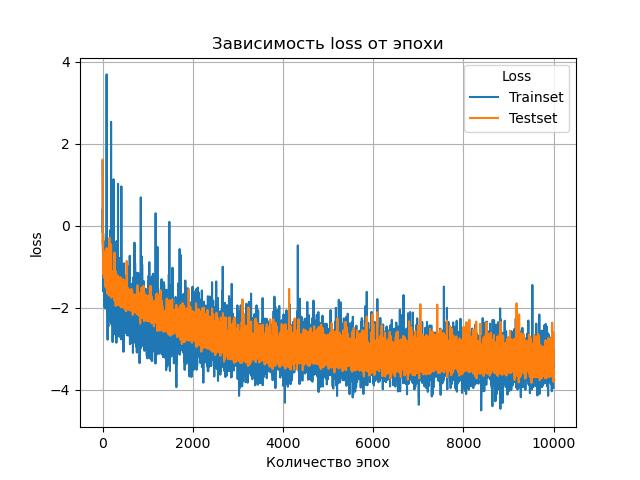

In [61]:
plt.plot(np.log(train_losses[0:-1]))
plt.plot(np.log(test_losses[0:-1]))
#plt.xticks(np.arange(0, 10000, 3000))
plt.grid(True)
plt.xlabel('Количество эпох')
plt.ylabel('loss')
plt.title('Зависимость loss от эпохи')
plt.legend(title='Loss',loc='upper right', labels=['Trainset', 'Testset'])